# Assignment 2: CNNs for image classification

In [145]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision.models import resnet18, vgg16, mobilenet_v2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from itertools import product
from collections import Counter

In [2]:
# Choosing the GPU as device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [70]:
# Hyperparameters for experiments
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [32, 64, 128]
optimizers = [optim.SGD, optim.Adam]
epochs = 50
patience = 5

## 1. Exploring and Preparing the Data

### 1.1 Loading and Exporing the Data

In [4]:
# Transformation without normalization
transform = transforms.Compose([transforms.ToTensor()])

# Load CIFAR-10 datasets
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

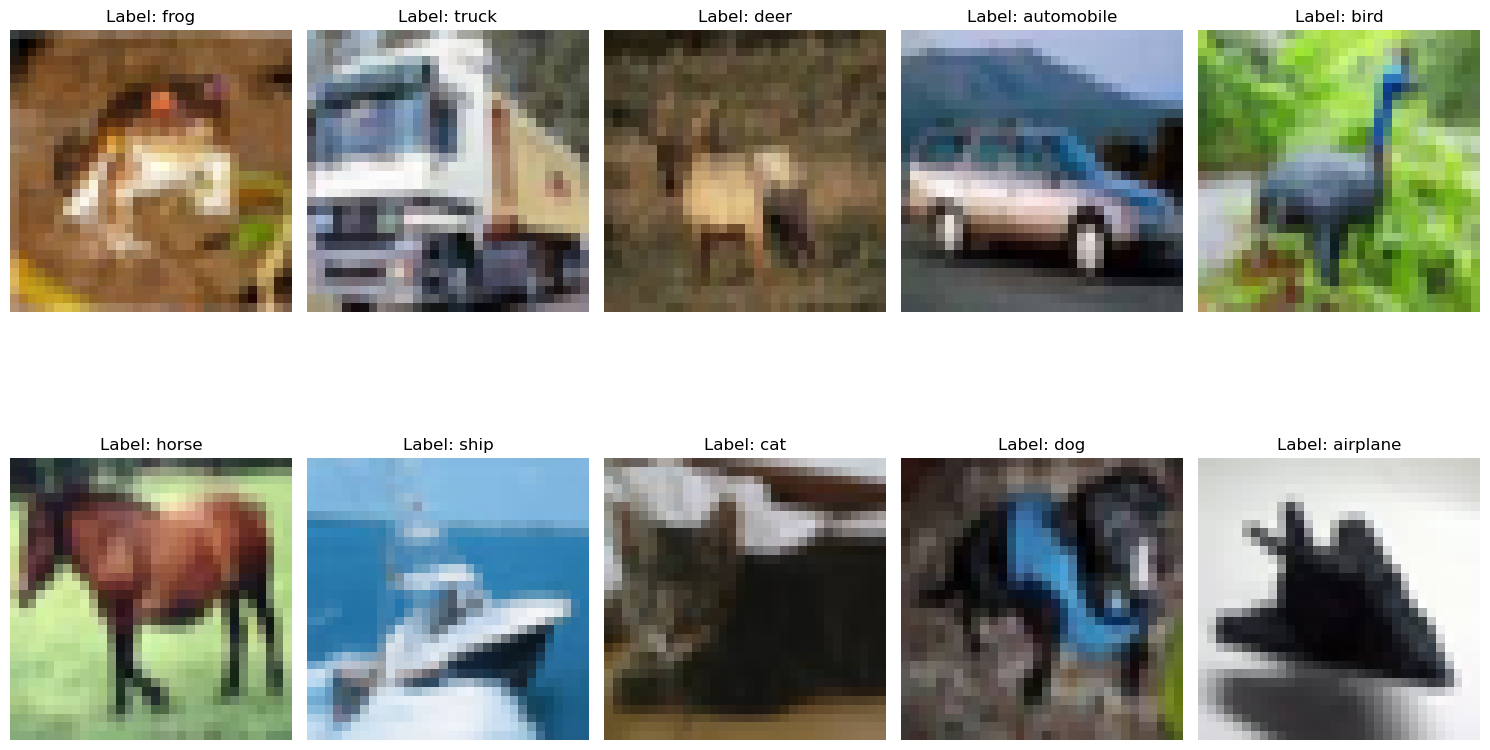

In [5]:
# Display sample images from each class
def show_sample_images_per_class(dataset):
    class_num = {}

    for i, (image, label) in enumerate(dataset):
        if label not in class_num:
            class_num[label] = i
        if len(class_num) == len(dataset.classes):
            break

    # Plot images
    fig, axes = plt.subplots(2, 5, figsize=(15, 10))
    axes = axes.flatten()
    for i, (label, index) in enumerate(class_num.items()):
        image, _ = dataset[index]
        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].axis('off')
        axes[i].set_title(f"Label: {dataset.classes[label]}")
    
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

show_sample_images_per_class(full_train_dataset)


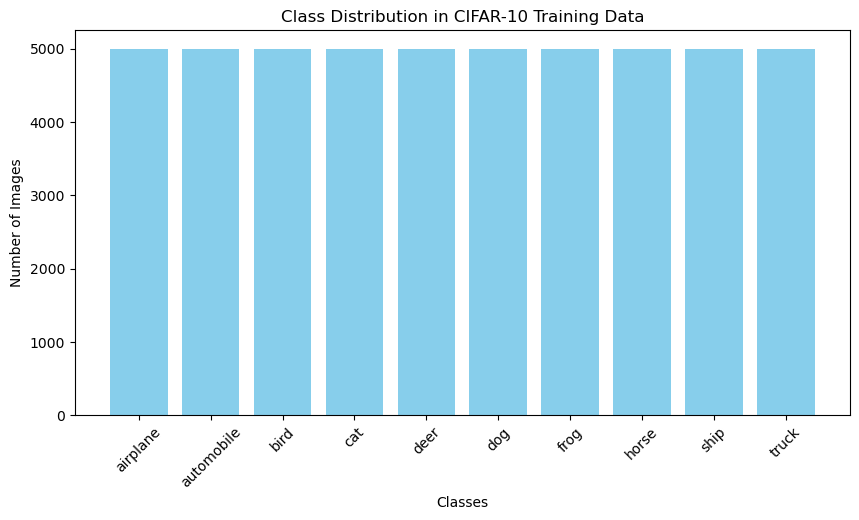

In [6]:
# Show class distribution
def plot_class_distribution(dataset):
    labels = dataset.targets
    class_counts = Counter(labels)
    classes = dataset.classes
    plt.figure(figsize=(10, 5))
    plt.bar(classes, class_counts.values(), color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution in CIFAR-10 Training Data')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(full_train_dataset)

In [7]:
# Check a few image sizes
for i in range(10):
    image, label = full_train_dataset[i]
    print(f"Image {i+1} - Shape: {image.shape}")

Image 1 - Shape: torch.Size([3, 32, 32])
Image 2 - Shape: torch.Size([3, 32, 32])
Image 3 - Shape: torch.Size([3, 32, 32])
Image 4 - Shape: torch.Size([3, 32, 32])
Image 5 - Shape: torch.Size([3, 32, 32])
Image 6 - Shape: torch.Size([3, 32, 32])
Image 7 - Shape: torch.Size([3, 32, 32])
Image 8 - Shape: torch.Size([3, 32, 32])
Image 9 - Shape: torch.Size([3, 32, 32])
Image 10 - Shape: torch.Size([3, 32, 32])


### 1.2 Preprocessing the Data

In [8]:
# Stratified Split of the full train dataset into training and validation sets
indices = list(range(len(full_train_dataset)))
labels = full_train_dataset.targets

train_indices, val_indices = train_test_split(indices, test_size=10000, stratify=labels, random_state=42)
train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_train_dataset, val_indices)

In [9]:
# Calculate the mean and standard deviation for normalization
def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=100, shuffle=False, num_workers=2)
    mean = 0.0
    std = 0.0
    total_images = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images
    return mean, std

mean, std = calculate_mean_std(train_dataset)
print('Mean:', mean)
print('Standard Deviation:', std)

Mean: tensor([0.4911, 0.4821, 0.4466])
Standard Deviation: tensor([0.2023, 0.1995, 0.2010])


In [10]:
# Transformation pipelines for the train, val and test set

# Train: Simple Data Augmentation for a better generalisation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

In [11]:
# Transform the datasets
train_dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
test_dataset.transform = val_transform

In [16]:
# Checking the sizes of the datasets
print(f'Training Set Size: {len(train_dataset)} images')
print(f'Validation Set Size: {len(val_dataset)} images')
print(f'Test Set Size: {len(test_dataset)} images')

Training Set Size: 40000 images
Validation Set Size: 10000 images
Test Set Size: 10000 images


In [134]:
# Downsample the datasets for hyperparameter optimisation
def downsampling_dataset(dataset, labels, percentage=0.25):
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=percentage, random_state=42)
    for _, subset_indices in stratified_split.split(np.zeros(len(labels)), labels):
        return Subset(dataset, subset_indices)

train_labels = [label for _, label in train_dataset]
val_labels = [label for _, label in val_dataset]
test_labels = [label for _, label in test_dataset]

# Create balanced downsampled subsets
train_dataset_subset = downsampling_dataset(train_dataset, train_labels, percentage=0.25)
val_dataset_subset = downsampling_dataset(val_dataset, val_labels, percentage=0.25)
test_dataset_subset = downsampling_dataset(test_dataset, test_labels, percentage=0.25)



In [135]:
# Checking the sizes of the downsampled datasets
print(f'Downsampled Training Set Size: {len(train_dataset_subset)} images')
print(f'Downsampled Validation Set Size: {len(val_dataset_subset)} images')
print(f'Downsampled Validation Set Size: {len(test_dataset_subset)} images')

Downsampled Training Set Size: 10000 images
Downsampled Validation Set Size: 2500 images
Downsampled Validation Set Size: 2500 images


## 2.Model Implementation

In [38]:
# Define early stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [60]:
# Function to train and validate a model
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs, patience=5, device=device):
    train_acc, val_acc, train_loss, val_loss = [], [], [], []
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(epochs):
        # Training phase
        model.train()
        correct, total, running_loss = 0, 0, 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc.append(100 * correct / total)
        train_loss.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        correct, total, val_running_loss = 0, 0, 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss_batch = criterion(outputs, labels).item()
                val_running_loss += val_loss_batch
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc.append(100 * correct / total)
        val_loss.append(val_running_loss / len(val_loader))

        # Early stopping check
        early_stopping(val_loss[-1])  # Pass the latest validation loss to early stopping
        if early_stopping.early_stop:
            print(f'Early stopping after {epoch + 1} epochs.')
            break

    return train_acc, val_acc, train_loss, val_loss



In [23]:
# Function to display the accuracy and loss curves
def plot_results(train_acc, val_acc, train_loss, val_loss):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    # Accuracy
    axs[0].plot(train_acc, label="Train Accuracy")
    axs[0].plot(val_acc, label="Validation Accuracy")
    axs[0].set_title("Accuracy")
    axs[0].legend()
    # Loss
    axs[1].plot(train_loss, label="Train Loss")
    axs[1].plot(val_loss, label="Validation Loss")
    axs[1].set_title("Loss")
    plt.tight_layout()
    axs[1].legend()
    plt.show()

### 2.1 CNN Baseline Model

#### 2.1.1 Functions for the model and experimentation loops

In [45]:
# CNN baseline model with options for different adjustments
class BaselineCNN(nn.Module):
    def __init__(self, num_layers=2, kernel_size=3, use_batch_norm=False):
        super(BaselineCNN, self).__init__()
        layers = []
        in_channels = 3
        out_channels = 32

        for i in range(num_layers):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1))
            if use_batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2, 2))
            in_channels = out_channels
            out_channels *= 2

        self.features = nn.Sequential(*layers)
        
        self.classifier = None

    def forward(self, x):
        x = self.features(x)
        
        if self.classifier is None:
            num_features = x.shape[1] * x.shape[2] * x.shape[3]
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(num_features, 128),
                nn.ReLU(),
                nn.Linear(128, 10)
            ).to(x.device)

        x = self.classifier(x)
        return x


In [56]:
# Training Loop for Experiment 1: Varying Layer Depth
def run_layer_depth_experiment(train_dataset, val_dataset, num_layers_list, epochs, learning_rate, patience, device):
    for num_layers in num_layers_list:
        print(f"\nTraining with {num_layers} convolutional layers:")
        
        model = BaselineCNN(num_layers=num_layers).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

        train_acc, val_acc, train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience, device)
        
        print(f'Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.2f}%')
        print(f'Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_acc[-1]:.2f}%\n')
        
        plot_results(train_acc=train_acc, val_acc=val_acc, train_loss=train_loss, val_loss=val_loss)


In [66]:
# Training Loop for Experiment 2: Kernel Size Variation
def run_kernel_size_experiment(train_dataset, val_dataset, kernel_sizes, epochs, learning_rate, patience, device=device):
    for kernel_size in kernel_sizes:
        print(f"\nTraining with kernel size {kernel_size}:")

        model = BaselineCNN(kernel_size=kernel_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

        train_acc, val_acc, train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience, device)

        print(f'Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.2f}%')
        print(f'Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_acc[-1]:.2f}%\n')

        plot_results(train_acc=train_acc, val_acc=val_acc, train_loss=train_loss, val_loss=val_loss)


In [67]:
# Training Loop for Experiment 3: Batch Normalization
def run_batch_norm_experiment(train_dataset, val_dataset, use_batch_norm_list, epochs, learning_rate, patience, device):
    for use_batch_norm in use_batch_norm_list:
        print(f"\nTraining with batch normalization: {use_batch_norm}")

        model = BaselineCNN(use_batch_norm=use_batch_norm).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

        train_acc, val_acc, train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience, device)
        
        print(f'Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.2f}%')
        print(f'Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_acc[-1]:.2f}%\n')

        plot_results(train_acc=train_acc, val_acc=val_acc, train_loss=train_loss, val_loss=val_loss)


In [68]:
# Training Loop for Experiment 4: Learning Rate and Optimizer Tuning
def run_optimizer_lr_experiment(train_dataset, val_dataset, learning_rates, optimizers, epochs, patience, device):
    for lr, optimizer_class in product(learning_rates, optimizers):
        print(f"\nTraining with learning rate {lr} and optimizer {optimizer_class.__name__}")

        model = BaselineCNN().to(device)
        optimizer = optimizer_class(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

        train_acc, val_acc, train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience, device)
        
        print(f'Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.2f}%')
        print(f'Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_acc[-1]:.2f}%\n')

        plot_results(train_acc=train_acc, val_acc=val_acc, train_loss=train_loss, val_loss=val_loss)

In [113]:
# Training Loop for Experiment 5: Learning Rate and Optimizer Tuning
def final_baseline_experiment(train_dataset, val_dataset, num_layers_list, use_batch_norm_list, epochs, learning_rates, optimizers, patience, device):
    for num_layers, use_batch_norm, lr, optimizer_class in product(num_layers_list, use_batch_norm_list, learning_rates, optimizers):
        print(f"\nTraining with: Layers={num_layers}, BatchNorm={use_batch_norm}, LR={lr}, Optimizer={optimizer_class.__name__}")

        model = BaselineCNN(num_layers=num_layers, kernel_size=5, use_batch_norm=use_batch_norm).to(device)
        
        optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()

        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

        train_acc, val_acc, train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience, device)
        
        print(f'Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.2f}%')
        print(f'Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_acc[-1]:.2f}%\n')

        plot_results(train_acc=train_acc, val_acc=val_acc, train_loss=train_loss, val_loss=val_loss)


#### 2.1.2 Experiments


Training with 2 convolutional layers:
Early stopping after 41 epochs.
Train Loss: 1.1804, Train Accuracy: 59.50%
Val Loss: 1.5271, Val Accuracy: 47.32%



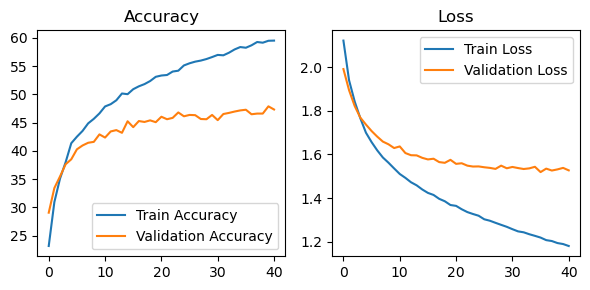


Training with 3 convolutional layers:
Early stopping after 16 epochs.
Train Loss: 0.6370, Train Accuracy: 78.45%
Val Loss: 1.3005, Val Accuracy: 59.36%



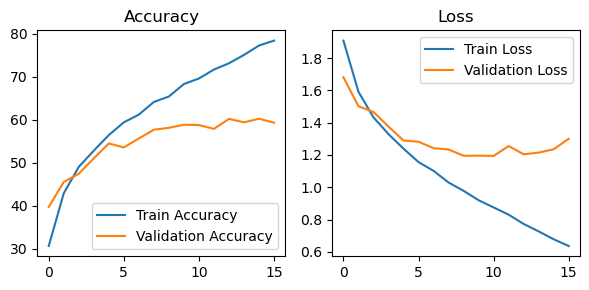

In [61]:
# Experiment 1: Varying Layer Depth
run_layer_depth_experiment(train_dataset_subset, val_dataset_subset, num_layers_list=[2, 3], epochs=50, learning_rate=0.001, patience=5, device=device)


Training with kernel size 3:
Train Loss: 1.1268, Train Accuracy: 61.52%
Val Loss: 1.4675, Val Accuracy: 49.04%



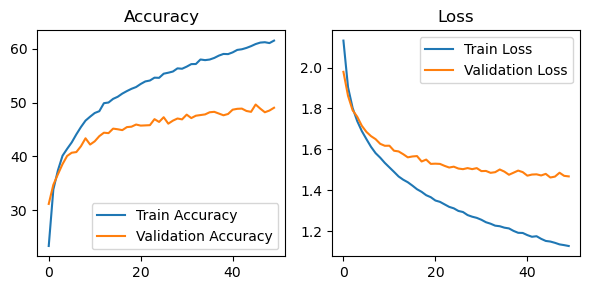


Training with kernel size 5:
Early stopping after 18 epochs.
Train Loss: 1.0225, Train Accuracy: 65.19%
Val Loss: 1.4691, Val Accuracy: 50.12%



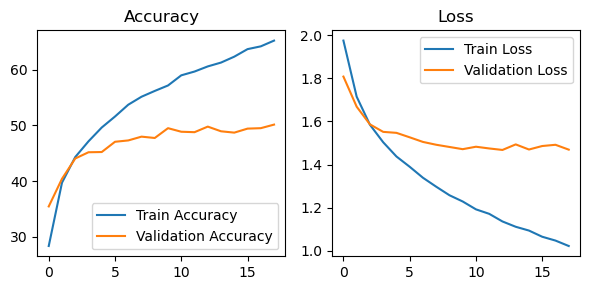

In [83]:
# Experiment 2: Kernel Size Variation
run_kernel_size_experiment(train_dataset_subset, val_dataset_subset, kernel_sizes=[3, 5], epochs=epochs, learning_rate=0.001, patience=5, device=device)


Training with batch normalization: False
Early stopping after 50 epochs.
Train Loss: 1.1122, Train Accuracy: 62.12%
Val Loss: 1.4886, Val Accuracy: 48.16%



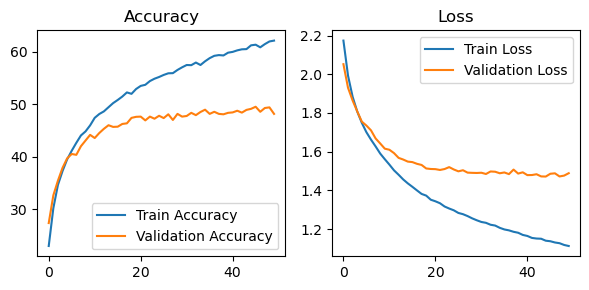


Training with batch normalization: True
Train Loss: 0.9177, Train Accuracy: 74.19%
Val Loss: 1.3855, Val Accuracy: 51.44%



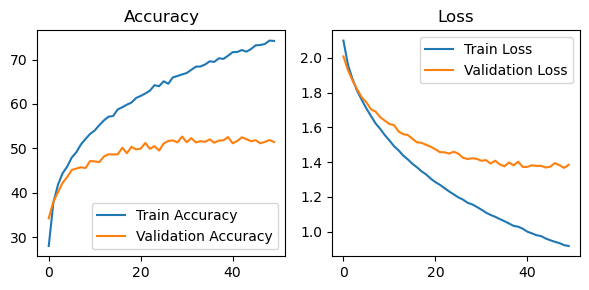

In [84]:
# Experiment 3: Batch Normalization
run_batch_norm_experiment(train_dataset_subset, val_dataset_subset, use_batch_norm_list=[False, True], epochs=epochs, learning_rate=0.001, patience=5, device=device)


Training with learning rate 0.0001 and optimizer SGD
Train Loss: 2.2990, Train Accuracy: 12.52%
Val Loss: 2.2995, Val Accuracy: 13.72%



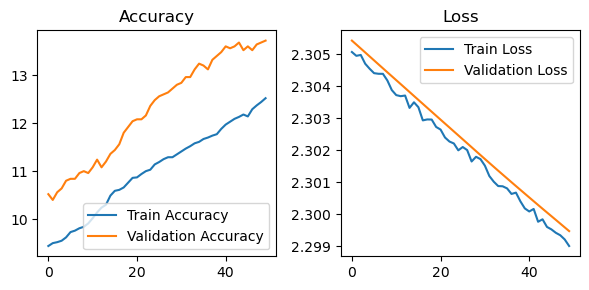


Training with learning rate 0.0001 and optimizer Adam
Train Loss: 1.6424, Train Accuracy: 42.30%
Val Loss: 1.7211, Val Accuracy: 38.68%



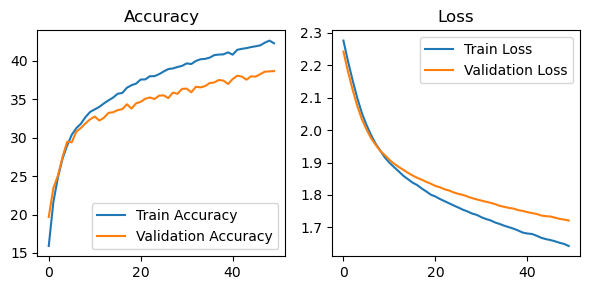


Training with learning rate 0.001 and optimizer SGD
Train Loss: 2.2344, Train Accuracy: 21.41%
Val Loss: 2.2343, Val Accuracy: 22.00%



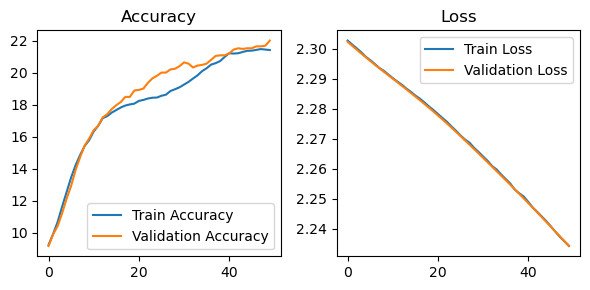


Training with learning rate 0.001 and optimizer Adam
Early stopping after 39 epochs.
Train Loss: 1.1999, Train Accuracy: 58.52%
Val Loss: 1.4866, Val Accuracy: 47.88%



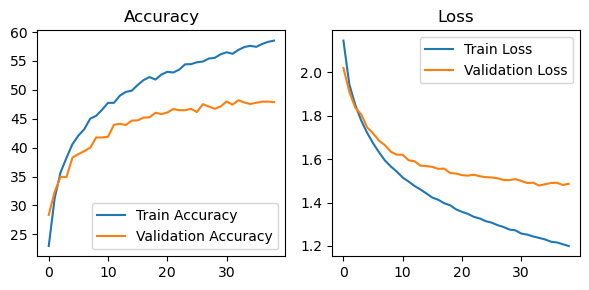


Training with learning rate 0.01 and optimizer SGD
Train Loss: 1.8960, Train Accuracy: 32.96%
Val Loss: 1.9175, Val Accuracy: 32.12%



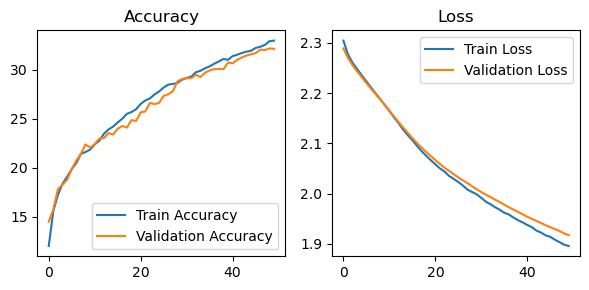


Training with learning rate 0.01 and optimizer Adam
Early stopping after 13 epochs.
Train Loss: 1.1783, Train Accuracy: 59.17%
Val Loss: 1.5807, Val Accuracy: 47.36%



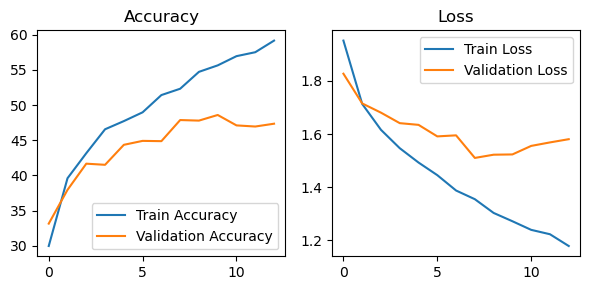

In [85]:
# Experiment 4: Learning Rate and Optimizer Tuning
run_optimizer_lr_experiment(train_dataset_subset, val_dataset_subset, learning_rates=[0.0001, 0.001, 0.01], optimizers=[optim.SGD, optim.Adam], epochs=epochs, patience=5, device=device)


Training with: Layers=3, BatchNorm=True, LR=0.0001, Optimizer=Adam
Train Loss: 0.6628, Train Accuracy: 91.79%
Val Loss: 1.1709, Val Accuracy: 64.76%



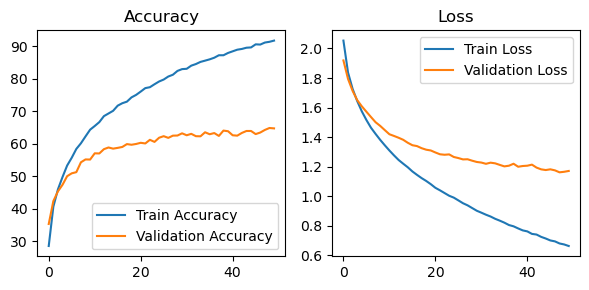

In [115]:
# Experiment 5: Combination of previous experiments based on results
final_baseline_experiment(train_dataset=train_dataset_subset,
    val_dataset=val_dataset_subset,
    num_layers_list=[3],
    use_batch_norm_list=[True],
    epochs=50,
    learning_rates=[0.0001],
    optimizers=[optim.Adam],
    patience=5,
    device=device
)

### 2.2 Resnet-18

#### 2.2.1 Functions for the model and hyperparameter optimisation

In [86]:
# Define the resnet18 model with choice of modifications
def get_resnet18(modify_first_layer=False):
    model = resnet18(weights=None)
    if modify_first_layer:
        model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

In [87]:
# Define a hyperparameter optimisation function for resnet18 with results and curves of each hyperparameter combination
def run_resnet18_experiment(train_dataset, val_dataset, learning_rates, batch_sizes, optimizers, epochs, device, patience, modify_first_layer=False):
    best_val_accuracy = 0
    best_params = {}

    # Iterate over all combinations of hyperparameters
    for lr, batch_size, optimizer_class in product(learning_rates, batch_sizes, optimizers):
        print(f'\nTesting combination: Learning Rate={lr}, Batch Size={batch_size}, Optimizer={optimizer_class.__name__}, Device = {device}')

        model = get_resnet18(modify_first_layer=modify_first_layer).to(device)

        optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=1e-4)
        criterion = torch.nn.CrossEntropyLoss()

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        train_acc, val_acc, train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience, device)

        print(f'Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.2f}%')
        print(f'Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_acc[-1]:.2f}%\n')

        plot_results(train_acc=train_acc, val_acc=val_acc, train_loss=train_loss, val_loss=val_loss)

        if val_acc[-1] > best_val_accuracy:
            best_val_accuracy = val_acc[-1]
            best_params = {
                'learning_rate': lr,
                'batch_size': batch_size,
                'optimizer': optimizer_class.__name__,
                'modify_first_layer': modify_first_layer,
                'best_train_loss': train_loss[-1],
                'best_train_accuracy': train_acc[-1],
                'best_val_loss': val_loss[-1],
                'best_val_accuracy': val_acc[-1]
            }

    print('\nBest Configuration:', best_params)
    return best_params, best_val_accuracy


#### 2.2.2 Experiments


Testing combination: Learning Rate=0.01, Batch Size=32, Optimizer=SGD, Device = mps
Early stopping after 9 epochs.
Train Loss: 0.3851, Train Accuracy: 86.58%
Val Loss: 2.0565, Val Accuracy: 45.72%



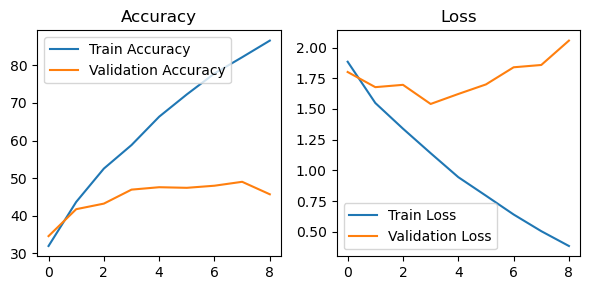


Testing combination: Learning Rate=0.01, Batch Size=32, Optimizer=Adam, Device = mps
Early stopping after 19 epochs.
Train Loss: 0.8152, Train Accuracy: 71.69%
Val Loss: 1.1199, Val Accuracy: 61.12%



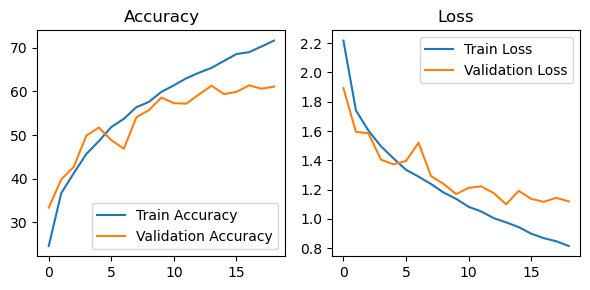


Testing combination: Learning Rate=0.01, Batch Size=64, Optimizer=SGD, Device = mps
Early stopping after 9 epochs.
Train Loss: 0.2605, Train Accuracy: 91.74%
Val Loss: 2.3096, Val Accuracy: 43.64%



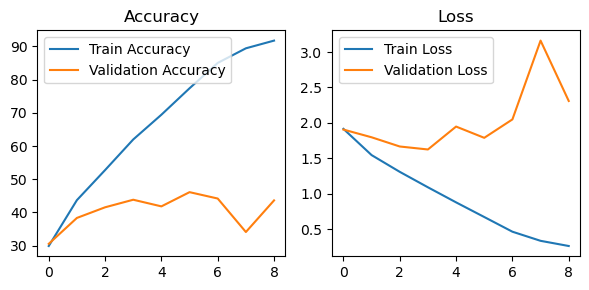


Testing combination: Learning Rate=0.01, Batch Size=64, Optimizer=Adam, Device = mps
Early stopping after 20 epochs.
Train Loss: 0.5821, Train Accuracy: 79.34%
Val Loss: 1.3049, Val Accuracy: 60.32%



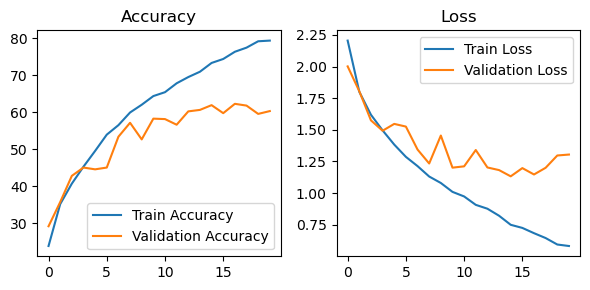


Testing combination: Learning Rate=0.01, Batch Size=128, Optimizer=SGD, Device = mps
Early stopping after 8 epochs.
Train Loss: 0.4806, Train Accuracy: 86.38%
Val Loss: 2.5077, Val Accuracy: 33.72%



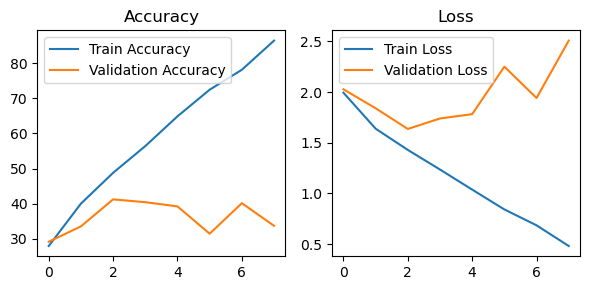


Testing combination: Learning Rate=0.01, Batch Size=128, Optimizer=Adam, Device = mps
Early stopping after 16 epochs.
Train Loss: 0.6427, Train Accuracy: 77.18%
Val Loss: 1.3172, Val Accuracy: 60.44%



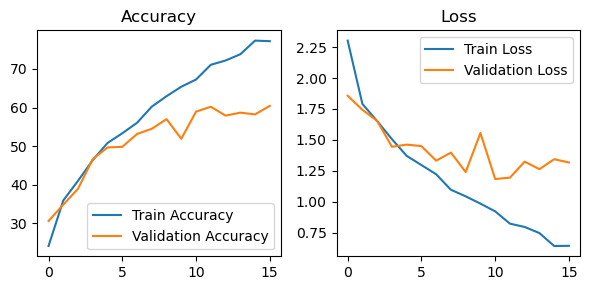


Testing combination: Learning Rate=0.001, Batch Size=32, Optimizer=SGD, Device = mps
Early stopping after 15 epochs.
Train Loss: 0.6252, Train Accuracy: 80.79%
Val Loss: 1.6361, Val Accuracy: 46.56%



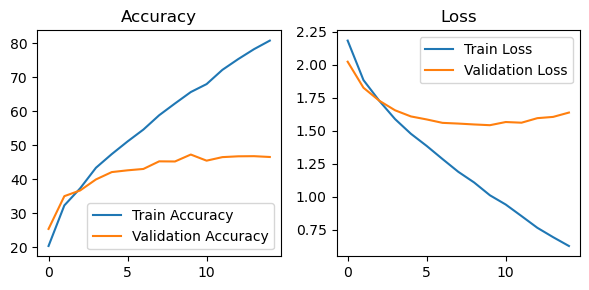


Testing combination: Learning Rate=0.001, Batch Size=32, Optimizer=Adam, Device = mps
Early stopping after 10 epochs.
Train Loss: 0.4465, Train Accuracy: 84.28%
Val Loss: 1.2822, Val Accuracy: 62.00%



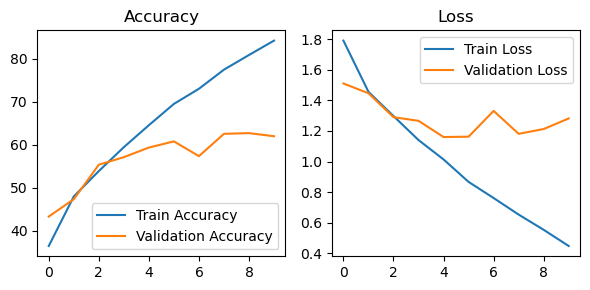


Testing combination: Learning Rate=0.001, Batch Size=64, Optimizer=SGD, Device = mps
Early stopping after 16 epochs.
Train Loss: 0.7513, Train Accuracy: 78.73%
Val Loss: 1.6816, Val Accuracy: 42.00%



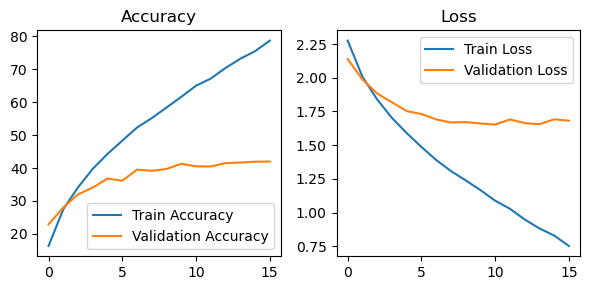


Testing combination: Learning Rate=0.001, Batch Size=64, Optimizer=Adam, Device = mps
Early stopping after 11 epochs.
Train Loss: 0.2942, Train Accuracy: 89.67%
Val Loss: 1.5583, Val Accuracy: 59.72%



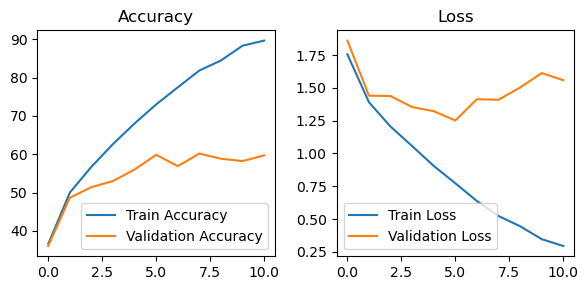


Testing combination: Learning Rate=0.001, Batch Size=128, Optimizer=SGD, Device = mps
Early stopping after 30 epochs.
Train Loss: 0.5502, Train Accuracy: 88.36%
Val Loss: 1.7067, Val Accuracy: 39.88%



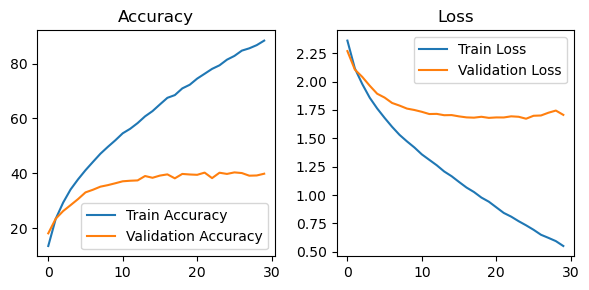


Testing combination: Learning Rate=0.001, Batch Size=128, Optimizer=Adam, Device = mps
Early stopping after 10 epochs.
Train Loss: 0.3034, Train Accuracy: 89.40%
Val Loss: 1.7121, Val Accuracy: 56.20%



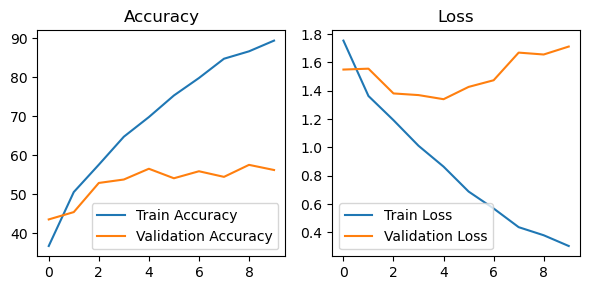


Testing combination: Learning Rate=0.0001, Batch Size=32, Optimizer=SGD, Device = mps
Train Loss: 1.0995, Train Accuracy: 63.38%
Val Loss: 1.6254, Val Accuracy: 42.20%



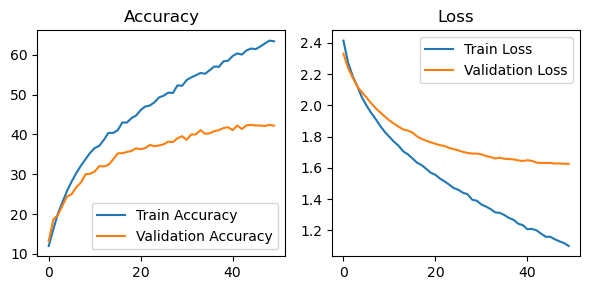


Testing combination: Learning Rate=0.0001, Batch Size=32, Optimizer=Adam, Device = mps
Early stopping after 8 epochs.
Train Loss: 0.2385, Train Accuracy: 92.10%
Val Loss: 2.1609, Val Accuracy: 47.72%



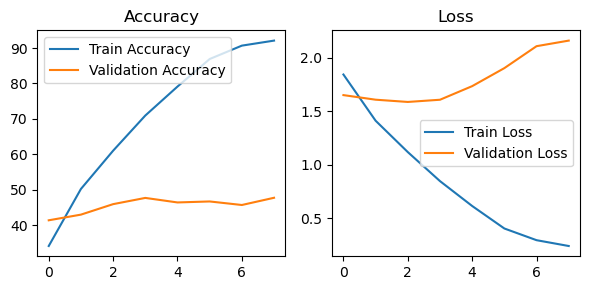


Testing combination: Learning Rate=0.0001, Batch Size=64, Optimizer=SGD, Device = mps
Train Loss: 1.3342, Train Accuracy: 56.14%
Val Loss: 1.7576, Val Accuracy: 36.76%



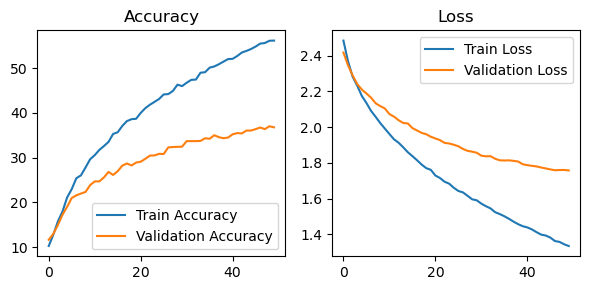


Testing combination: Learning Rate=0.0001, Batch Size=64, Optimizer=Adam, Device = mps
Early stopping after 7 epochs.
Train Loss: 0.1354, Train Accuracy: 96.65%
Val Loss: 2.2351, Val Accuracy: 43.32%



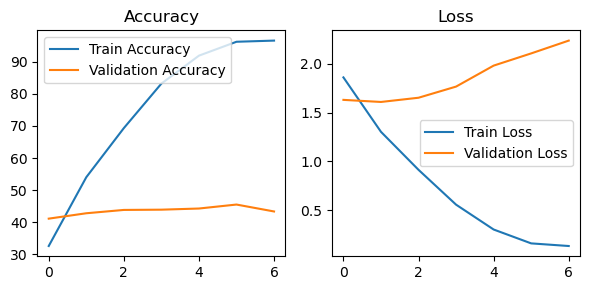


Testing combination: Learning Rate=0.0001, Batch Size=128, Optimizer=SGD, Device = mps
Train Loss: 1.5945, Train Accuracy: 47.06%
Val Loss: 1.9428, Val Accuracy: 30.12%



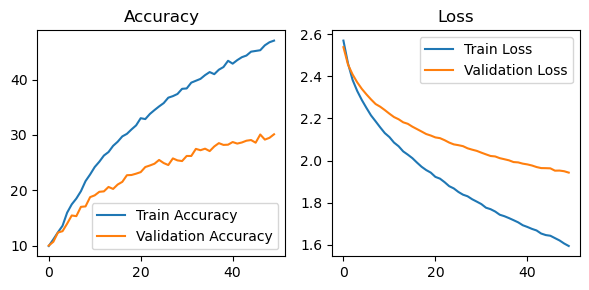


Testing combination: Learning Rate=0.0001, Batch Size=128, Optimizer=Adam, Device = mps
Early stopping after 7 epochs.
Train Loss: 0.0790, Train Accuracy: 99.18%
Val Loss: 2.1396, Val Accuracy: 42.88%



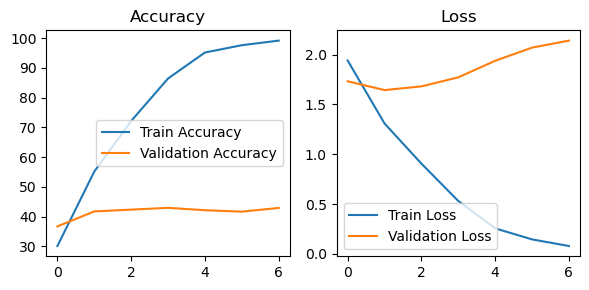


Best Configuration: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'Adam', 'modify_first_layer': False, 'best_train_loss': 0.44653707077375615, 'best_train_accuracy': 84.28, 'best_val_loss': 1.2822208955318113, 'best_val_accuracy': 62.0}


In [90]:
# Hyperparameter optimisation without modifications of the first layer
best_params, best_val_accuracy = run_resnet18_experiment(
    train_dataset=train_dataset_subset,
    val_dataset=val_dataset_subset,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    optimizers=optimizers,
    epochs=epochs,
    patience=5,
    device=device,
    modify_first_layer=False
)


Testing combination: Learning Rate=0.01, Batch Size=32, Optimizer=SGD, Device = mps
Early stopping after 9 epochs.
Train Loss: 0.3168, Train Accuracy: 90.94%
Val Loss: 1.6971, Val Accuracy: 50.44%



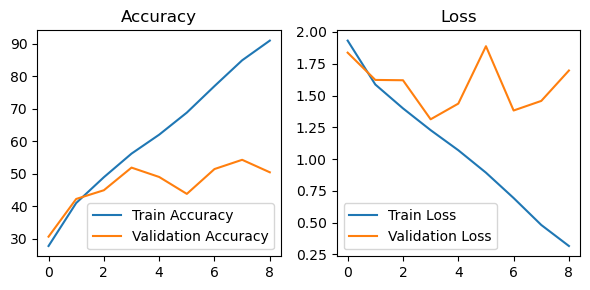


Testing combination: Learning Rate=0.01, Batch Size=32, Optimizer=Adam, Device = mps
Early stopping after 28 epochs.
Train Loss: 0.7636, Train Accuracy: 72.49%
Val Loss: 1.4104, Val Accuracy: 55.96%



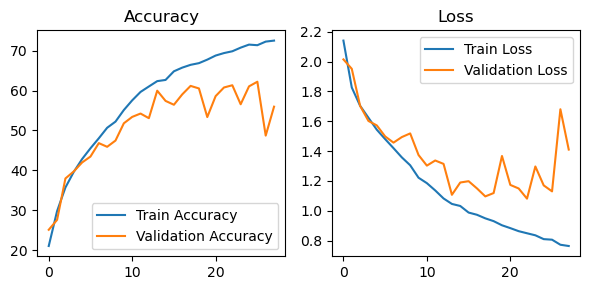


Testing combination: Learning Rate=0.01, Batch Size=64, Optimizer=SGD, Device = mps
Early stopping after 14 epochs.
Train Loss: 0.0973, Train Accuracy: 99.09%
Val Loss: 1.6744, Val Accuracy: 50.08%



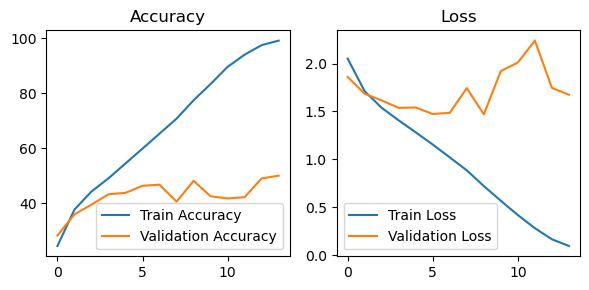


Testing combination: Learning Rate=0.01, Batch Size=64, Optimizer=Adam, Device = mps
Early stopping after 21 epochs.
Train Loss: 0.6528, Train Accuracy: 76.92%
Val Loss: 1.1591, Val Accuracy: 61.68%



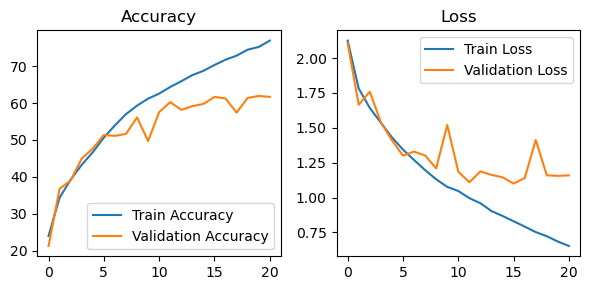


Testing combination: Learning Rate=0.01, Batch Size=128, Optimizer=SGD, Device = mps
Early stopping after 14 epochs.
Train Loss: 0.7203, Train Accuracy: 78.98%
Val Loss: 1.8113, Val Accuracy: 42.28%



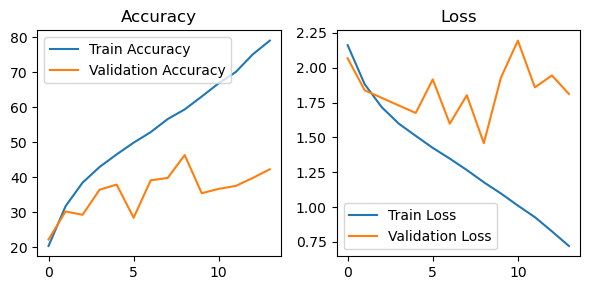


Testing combination: Learning Rate=0.01, Batch Size=128, Optimizer=Adam, Device = mps
Early stopping after 15 epochs.
Train Loss: 0.7731, Train Accuracy: 72.58%
Val Loss: 1.1170, Val Accuracy: 61.68%



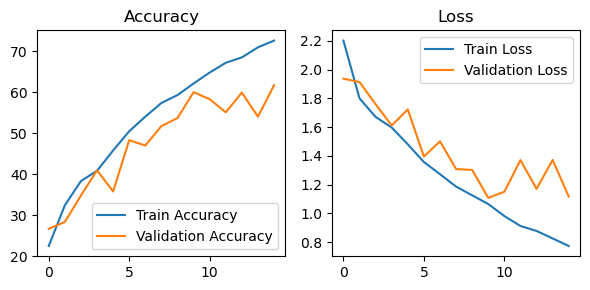


Testing combination: Learning Rate=0.001, Batch Size=32, Optimizer=SGD, Device = mps
Early stopping after 35 epochs.
Train Loss: 0.7486, Train Accuracy: 77.62%
Val Loss: 1.3656, Val Accuracy: 50.96%



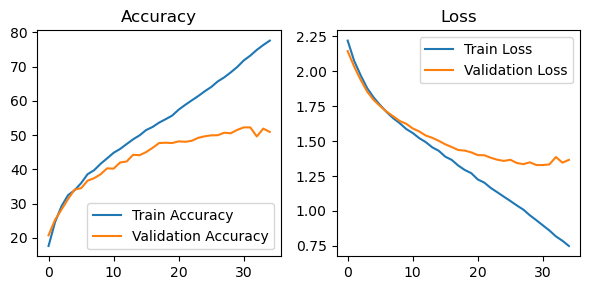


Testing combination: Learning Rate=0.001, Batch Size=32, Optimizer=Adam, Device = mps
Early stopping after 9 epochs.
Train Loss: 0.3724, Train Accuracy: 87.07%
Val Loss: 1.0221, Val Accuracy: 69.40%



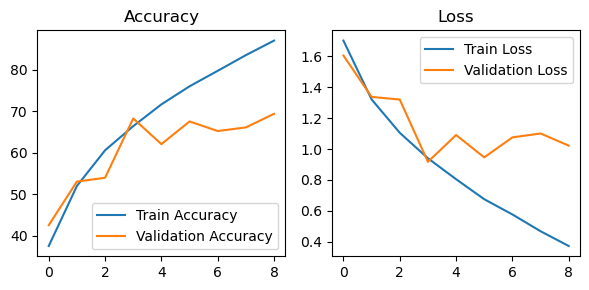


Testing combination: Learning Rate=0.001, Batch Size=64, Optimizer=SGD, Device = mps
Train Loss: 0.9184, Train Accuracy: 71.45%
Val Loss: 1.3695, Val Accuracy: 50.08%



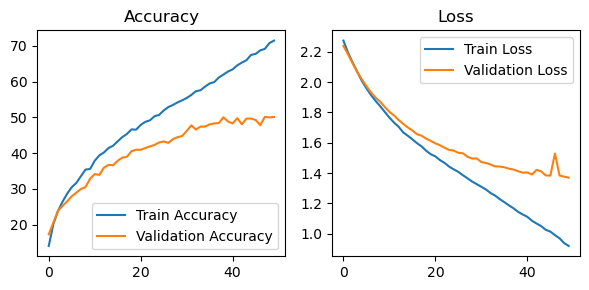


Testing combination: Learning Rate=0.001, Batch Size=64, Optimizer=Adam, Device = mps
Early stopping after 11 epochs.
Train Loss: 0.1926, Train Accuracy: 93.27%
Val Loss: 1.3016, Val Accuracy: 67.16%



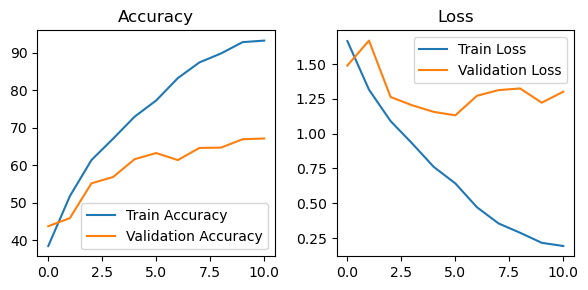


Testing combination: Learning Rate=0.001, Batch Size=128, Optimizer=SGD, Device = mps
Train Loss: 1.4035, Train Accuracy: 52.35%
Val Loss: 1.5746, Val Accuracy: 40.96%



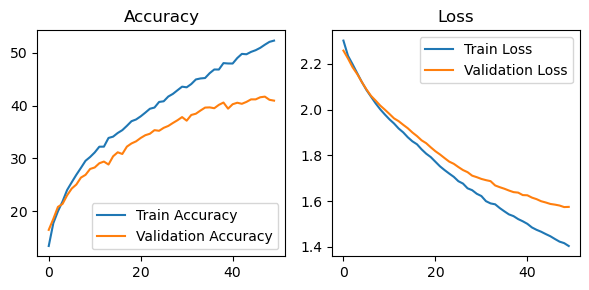


Testing combination: Learning Rate=0.001, Batch Size=128, Optimizer=Adam, Device = mps
Early stopping after 9 epochs.
Train Loss: 0.3204, Train Accuracy: 88.98%
Val Loss: 1.3221, Val Accuracy: 62.76%



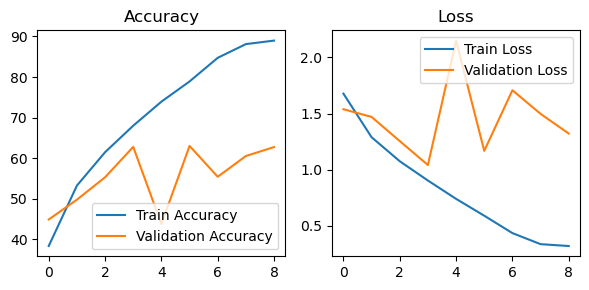


Testing combination: Learning Rate=0.0001, Batch Size=32, Optimizer=SGD, Device = mps
Train Loss: 1.7913, Train Accuracy: 37.05%
Val Loss: 1.8246, Val Accuracy: 34.04%



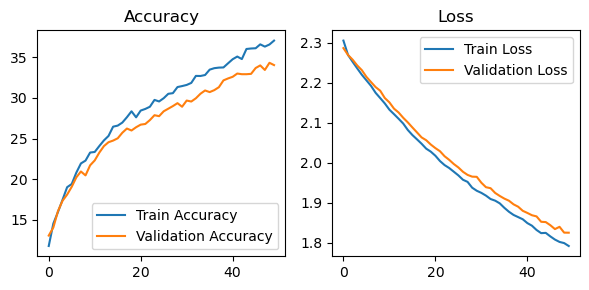


Testing combination: Learning Rate=0.0001, Batch Size=32, Optimizer=Adam, Device = mps
Early stopping after 7 epochs.
Train Loss: 0.0570, Train Accuracy: 98.79%
Val Loss: 1.8463, Val Accuracy: 51.72%



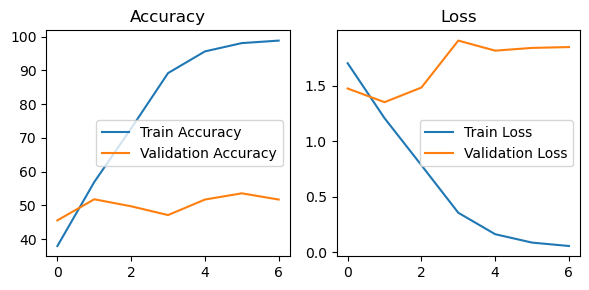


Testing combination: Learning Rate=0.0001, Batch Size=64, Optimizer=SGD, Device = mps
Train Loss: 1.9141, Train Accuracy: 32.04%
Val Loss: 1.9370, Val Accuracy: 27.56%



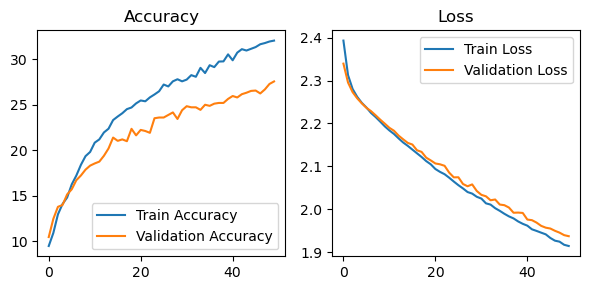


Testing combination: Learning Rate=0.0001, Batch Size=64, Optimizer=Adam, Device = mps
Early stopping after 7 epochs.
Train Loss: 0.0210, Train Accuracy: 99.81%
Val Loss: 1.8245, Val Accuracy: 49.56%



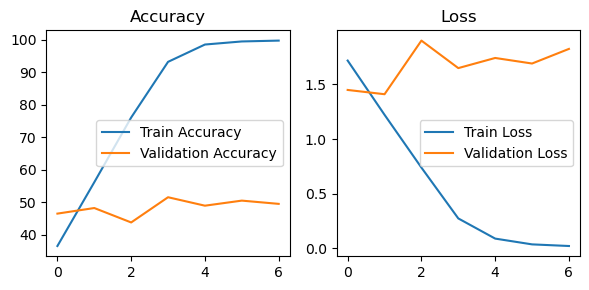


Testing combination: Learning Rate=0.0001, Batch Size=128, Optimizer=SGD, Device = mps
Train Loss: 2.0952, Train Accuracy: 25.87%
Val Loss: 2.1155, Val Accuracy: 23.16%



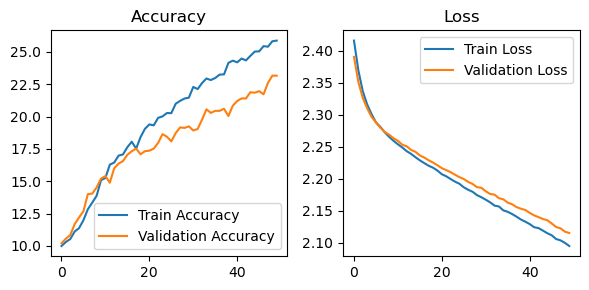


Testing combination: Learning Rate=0.0001, Batch Size=128, Optimizer=Adam, Device = mps
Early stopping after 7 epochs.
Train Loss: 0.0183, Train Accuracy: 99.96%
Val Loss: 1.6898, Val Accuracy: 48.24%



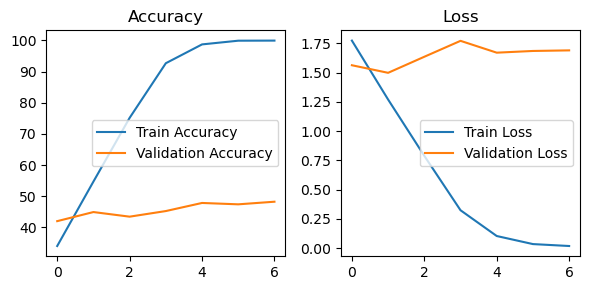


Best Configuration: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'Adam', 'modify_first_layer': True, 'best_train_loss': 0.37236292010393385, 'best_train_accuracy': 87.07, 'best_val_loss': 1.0220872197724595, 'best_val_accuracy': 69.4}


In [116]:
# Hyperparameter optimisation with modifications of the first layer
best_params, best_val_accuracy = run_resnet18_experiment(
    train_dataset=train_dataset_subset,
    val_dataset=val_dataset_subset,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    optimizers=optimizers,
    epochs=epochs,
    patience=5,
    device=device,
    modify_first_layer=True
)

### 2.3 VGG-16

#### 2.3.1 Functions for the model and hyperparameter optimisation

In [120]:
# Define the vgg16 model with only adjustments in the last layer
def get_vgg16():
   model = vgg16(weights=None)
   model.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
   model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)
   
   return model

In [126]:
# Define the vgg16 model with additional adjustments in the last layer and with batch normalization
def get_vgg16_modified():
    model = models.vgg16_bn(weights=None)
    model.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)  # Modify the last layer for CIFAR-10 (10 classes)
    return model

In [122]:
# Define a hyperparameter optimization function for VGG-16 with results and curves for each hyperparameter combination
def run_vgg16_experiment(train_dataset, val_dataset, learning_rates, batch_sizes, optimizers, epochs, device, patience, vgg16_getter):
    best_val_accuracy = 0
    best_params = {}

    # Iterate over all combinations of hyperparameters
    for lr, batch_size, optimizer_class in product(learning_rates, batch_sizes, optimizers):
        print(f'\nTesting combination: Learning Rate={lr}, Batch Size={batch_size}, Optimizer={optimizer_class.__name__}, Device={device}')

        # Create the model using the provided model getter
        model = vgg16_getter().to(device)

        # Set up the optimizer and loss function
        optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=1e-4)
        criterion = torch.nn.CrossEntropyLoss()

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Train and validate the model
        train_acc, val_acc, train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience, device)

        print(f'Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.2f}%')
        print(f'Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_acc[-1]:.2f}%\n')

        # Plot training results
        plot_results(train_acc=train_acc, val_acc=val_acc, train_loss=train_loss, val_loss=val_loss)

        # Track the best performing model
        if val_acc[-1] > best_val_accuracy:
            best_val_accuracy = val_acc[-1]
            best_params = {
                'learning_rate': lr,
                'batch_size': batch_size,
                'optimizer': optimizer_class.__name__,
                'best_train_loss': train_loss[-1],
                'best_train_accuracy': train_acc[-1],
                'best_val_loss': val_loss[-1],
                'best_val_accuracy': val_acc[-1]
            }

    print('\nBest Configuration:', best_params)
    return best_params, best_val_accuracy


#### 2.3.2 Experiments


Testing combination: Learning Rate=0.01, Batch Size=64, Optimizer=Adam, Device=mps
Early stopping after 9 epochs.
Train Loss: 8.6770, Train Accuracy: 10.02%
Val Loss: 2.3038, Val Accuracy: 10.00%



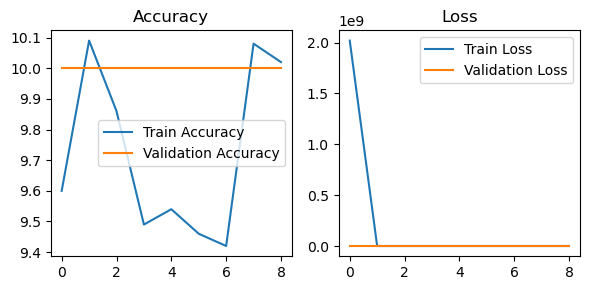


Best Configuration: {'learning_rate': 0.01, 'batch_size': 64, 'optimizer': 'Adam', 'best_train_loss': 8.67703999227779, 'best_train_accuracy': 10.02, 'best_val_loss': 2.3038105010986327, 'best_val_accuracy': 10.0}


In [123]:
# Experiment with only adjustments in the last layer

best_params, best_val_accuracy = run_vgg16_experiment(
    train_dataset=train_dataset_subset,
    val_dataset=val_dataset_subset,
    learning_rates=[0.01],
    batch_sizes=[64],
    optimizers=[optim.Adam],
    epochs=50,
    patience=5,
    device=device,
    vgg16_getter=get_vgg16
)


Testing combination: Learning Rate=0.01, Batch Size=32, Optimizer=SGD, Device=mps
Early stopping after 11 epochs.
Train Loss: 0.4032, Train Accuracy: 85.88%
Val Loss: 1.6435, Val Accuracy: 54.84%



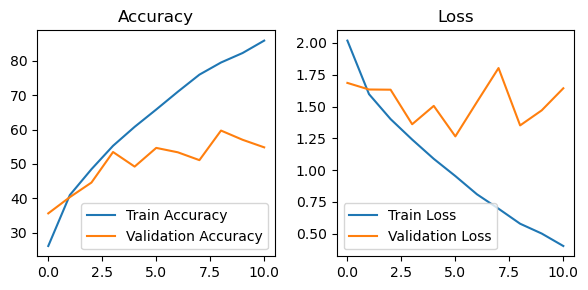


Testing combination: Learning Rate=0.01, Batch Size=32, Optimizer=Adam, Device=mps
Early stopping after 11 epochs.
Train Loss: 2.3769, Train Accuracy: 9.57%
Val Loss: 2.3121, Val Accuracy: 9.44%



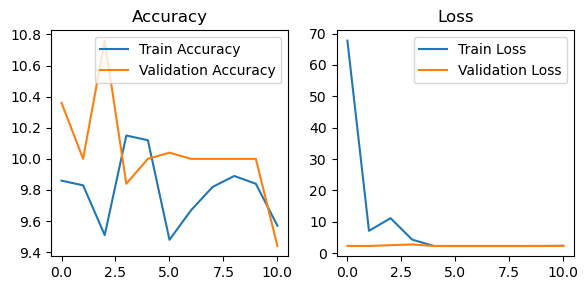


Testing combination: Learning Rate=0.01, Batch Size=64, Optimizer=SGD, Device=mps
Early stopping after 12 epochs.
Train Loss: 0.3119, Train Accuracy: 88.87%
Val Loss: 2.4260, Val Accuracy: 44.56%



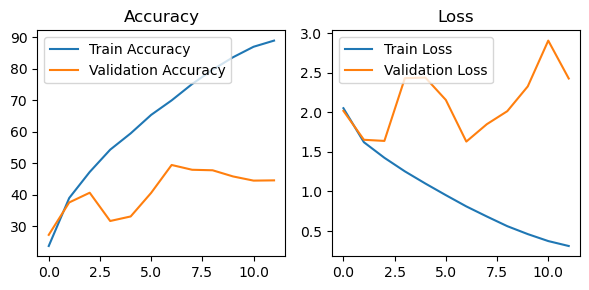


Testing combination: Learning Rate=0.01, Batch Size=64, Optimizer=Adam, Device=mps
Early stopping after 15 epochs.
Train Loss: 2.3051, Train Accuracy: 9.71%
Val Loss: 2.3031, Val Accuracy: 10.00%



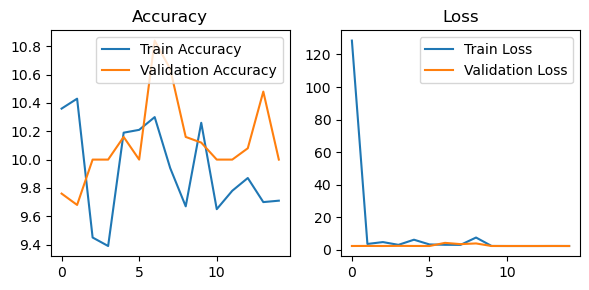


Testing combination: Learning Rate=0.01, Batch Size=128, Optimizer=SGD, Device=mps
Early stopping after 7 epochs.
Train Loss: 0.8645, Train Accuracy: 67.87%
Val Loss: 4.0140, Val Accuracy: 31.24%



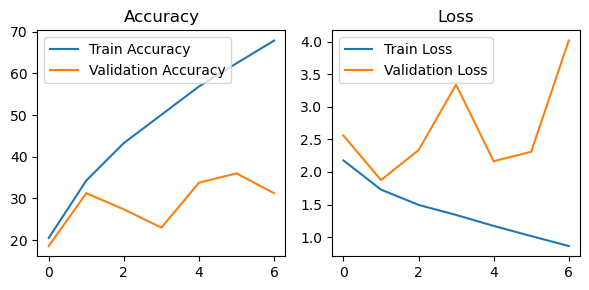


Testing combination: Learning Rate=0.01, Batch Size=128, Optimizer=Adam, Device=mps
Early stopping after 9 epochs.
Train Loss: 2.6409, Train Accuracy: 9.40%
Val Loss: 2.3237, Val Accuracy: 10.04%



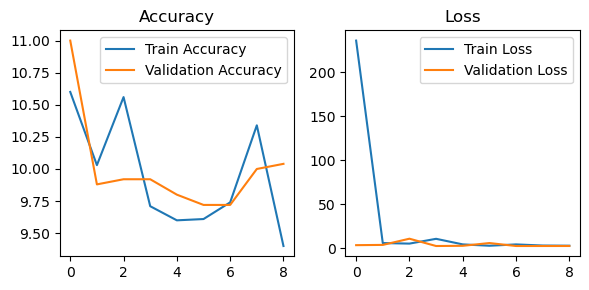


Testing combination: Learning Rate=0.001, Batch Size=32, Optimizer=SGD, Device=mps
Early stopping after 15 epochs.
Train Loss: 0.4461, Train Accuracy: 84.32%
Val Loss: 1.7213, Val Accuracy: 52.24%



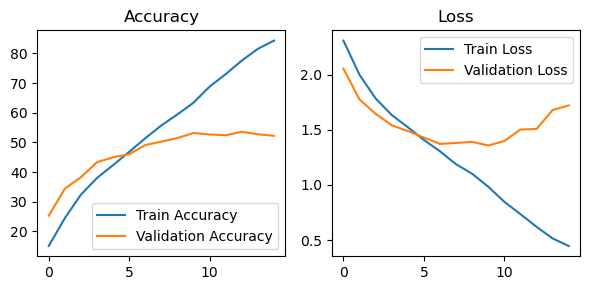


Testing combination: Learning Rate=0.001, Batch Size=32, Optimizer=Adam, Device=mps
Early stopping after 6 epochs.
Train Loss: 2.3114, Train Accuracy: 9.91%
Val Loss: 2.3030, Val Accuracy: 10.00%



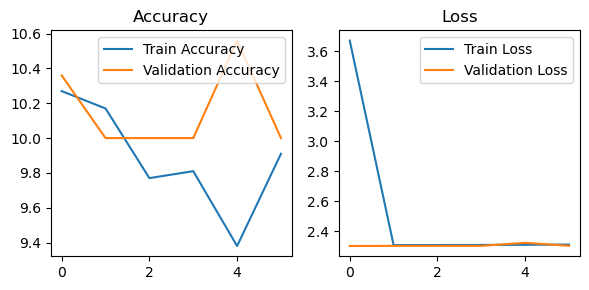


Testing combination: Learning Rate=0.001, Batch Size=64, Optimizer=SGD, Device=mps
Early stopping after 15 epochs.
Train Loss: 0.6849, Train Accuracy: 75.72%
Val Loss: 1.5481, Val Accuracy: 49.32%



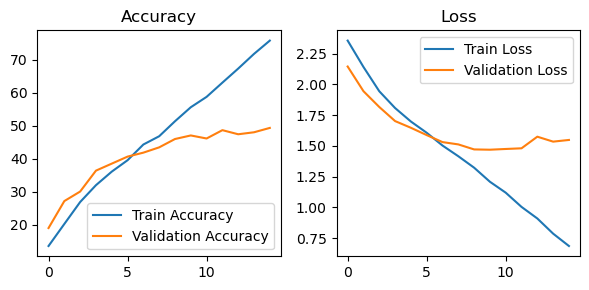


Testing combination: Learning Rate=0.001, Batch Size=64, Optimizer=Adam, Device=mps
Early stopping after 9 epochs.
Train Loss: 2.2728, Train Accuracy: 12.08%
Val Loss: 2.3050, Val Accuracy: 10.32%



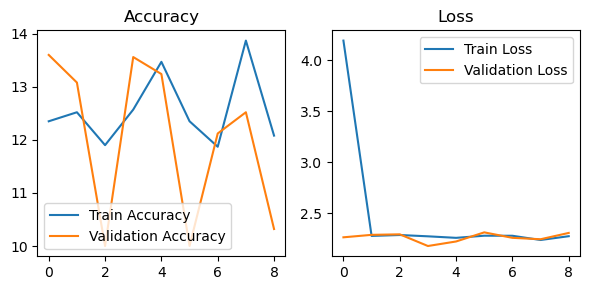


Testing combination: Learning Rate=0.001, Batch Size=128, Optimizer=SGD, Device=mps
Early stopping after 25 epochs.
Train Loss: 0.6106, Train Accuracy: 80.10%
Val Loss: 1.7488, Val Accuracy: 44.56%



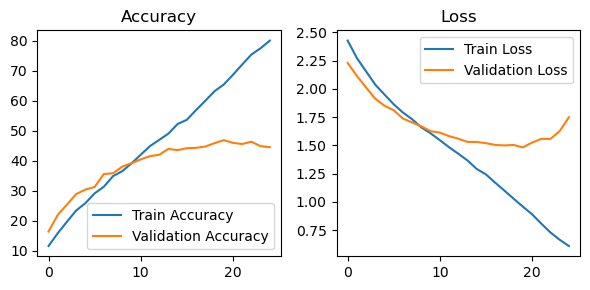


Testing combination: Learning Rate=0.001, Batch Size=128, Optimizer=Adam, Device=mps
Early stopping after 17 epochs.
Train Loss: 1.9364, Train Accuracy: 18.58%
Val Loss: 1.9070, Val Accuracy: 18.20%



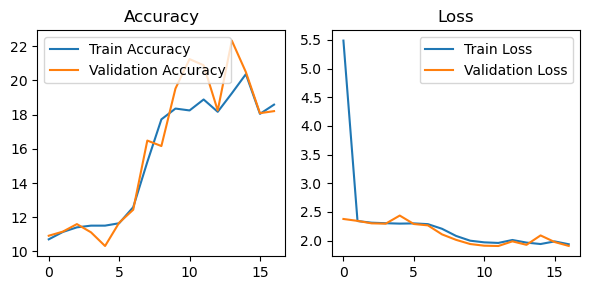


Testing combination: Learning Rate=0.0001, Batch Size=32, Optimizer=SGD, Device=mps
Train Loss: 1.1281, Train Accuracy: 58.66%
Val Loss: 1.4421, Val Accuracy: 48.16%



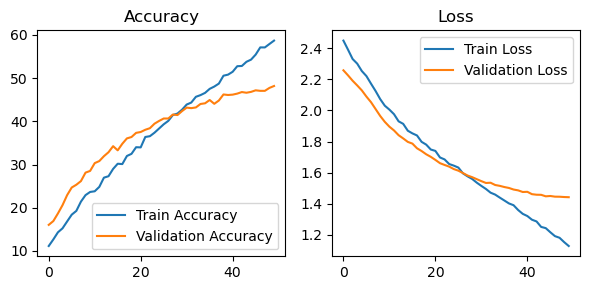


Testing combination: Learning Rate=0.0001, Batch Size=32, Optimizer=Adam, Device=mps
Early stopping after 11 epochs.
Train Loss: 0.3715, Train Accuracy: 88.09%
Val Loss: 1.6040, Val Accuracy: 57.08%



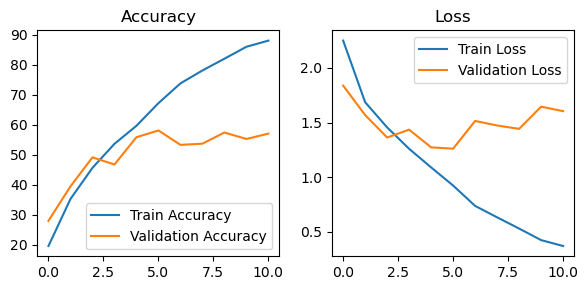


Testing combination: Learning Rate=0.0001, Batch Size=64, Optimizer=SGD, Device=mps
Train Loss: 1.5539, Train Accuracy: 42.41%
Val Loss: 1.6097, Val Accuracy: 39.52%



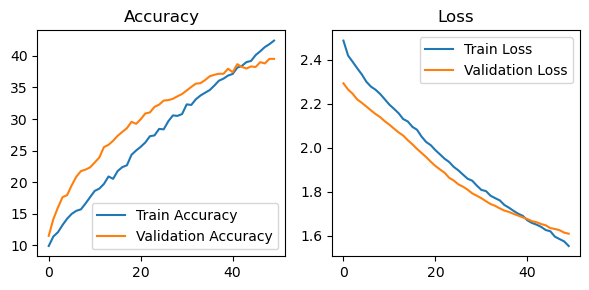


Testing combination: Learning Rate=0.0001, Batch Size=64, Optimizer=Adam, Device=mps
Early stopping after 10 epochs.
Train Loss: 0.2854, Train Accuracy: 90.49%
Val Loss: 1.6026, Val Accuracy: 57.64%



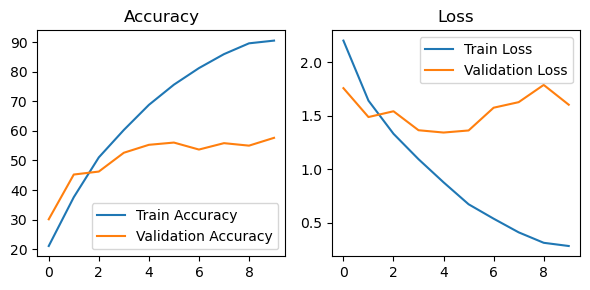


Testing combination: Learning Rate=0.0001, Batch Size=128, Optimizer=SGD, Device=mps
Train Loss: 1.8569, Train Accuracy: 29.85%
Val Loss: 1.7992, Val Accuracy: 34.44%



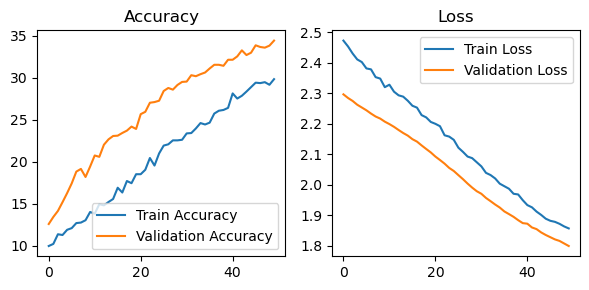


Testing combination: Learning Rate=0.0001, Batch Size=128, Optimizer=Adam, Device=mps
Early stopping after 9 epochs.
Train Loss: 0.2873, Train Accuracy: 90.51%
Val Loss: 2.1434, Val Accuracy: 52.08%



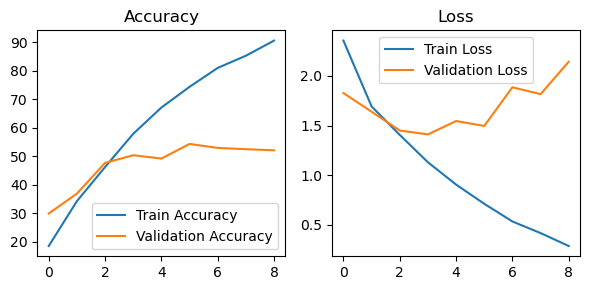


Best Configuration: {'learning_rate': 0.0001, 'batch_size': 64, 'optimizer': 'Adam', 'best_train_loss': 0.28541978197112966, 'best_train_accuracy': 90.49, 'best_val_loss': 1.6025712758302688, 'best_val_accuracy': 57.64}


In [127]:
# Hyperparameter optimisation with additional adjustments in the last layer and with batch normalization for CIFAR-10
best_params, best_val_accuracy = run_vgg16_experiment(
    train_dataset=train_dataset_subset,
    val_dataset=val_dataset_subset,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    optimizers=optimizers,
    epochs=50,
    patience=5,
    device=device,
    vgg16_getter=get_vgg16_modified
)

### 2.4 Mobilenet

#### 2.4.1 Functions for the model and hyperparameter optimisation

In [117]:
# Define the mobilenet Model
def get_mobilenet():
    model = mobilenet_v2(weights=None)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)
    return model

In [118]:
# Define a hyperparameter optimization function for MobileNet with results and curves for each hyperparameter combination
def run_mobilenet_experiment(train_dataset, val_dataset, learning_rates, batch_sizes, optimizers, epochs, patience, device):
    best_val_accuracy = 0
    best_params = {}

    # Iterate over all combinations of hyperparameters
    for lr, batch_size, optimizer_class in product(learning_rates, batch_sizes, optimizers):
        print(f'\nTesting combination: Learning Rate={lr}, Batch Size={batch_size}, Optimizer={optimizer_class.__name__}, Device = {device}')

        model = get_mobilenet().to(device)

        optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=1e-4)
        criterion = torch.nn.CrossEntropyLoss()

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        train_acc, val_acc, train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience, device)

        print(f'Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.2f}%')
        print(f'Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_acc[-1]:.2f}%\n')

        plot_results(train_acc=train_acc, val_acc=val_acc, train_loss=train_loss, val_loss=val_loss)

        if val_acc[-1] > best_val_accuracy:
            best_val_accuracy = val_acc[-1]
            best_params = {
                'learning_rate': lr,
                'batch_size': batch_size,
                'optimizer': optimizer_class.__name__,
                'best_train_loss': train_loss[-1],
                'best_train_accuracy': train_acc[-1],
                'best_val_loss': val_loss[-1],
                'best_val_accuracy': val_acc[-1]
            }

    print('\nBest Configuration:', best_params)
    return best_params, best_val_accuracy


#### 2.4.2 Experiments


Testing combination: Learning Rate=0.01, Batch Size=32, Optimizer=SGD, Device = mps
Early stopping after 25 epochs.
Train Loss: 1.0160, Train Accuracy: 63.39%
Val Loss: 1.5055, Val Accuracy: 46.92%



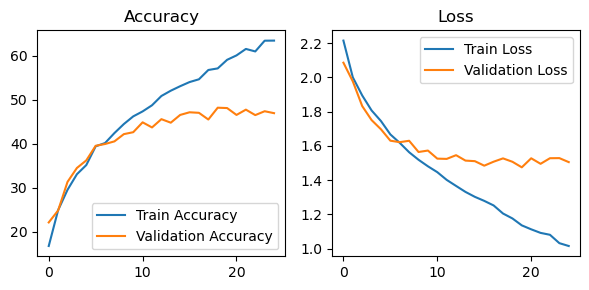


Testing combination: Learning Rate=0.01, Batch Size=32, Optimizer=Adam, Device = mps
Early stopping after 32 epochs.
Train Loss: 1.2054, Train Accuracy: 57.28%
Val Loss: 1.3988, Val Accuracy: 49.32%



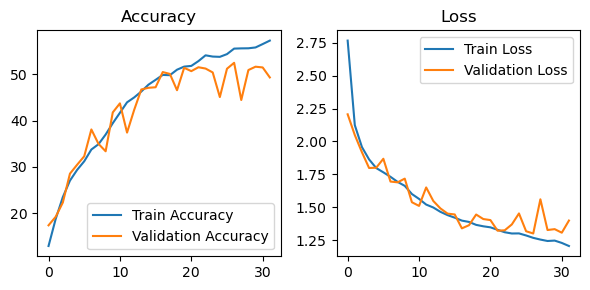


Testing combination: Learning Rate=0.01, Batch Size=64, Optimizer=SGD, Device = mps
Early stopping after 21 epochs.
Train Loss: 1.1362, Train Accuracy: 59.09%
Val Loss: 1.6222, Val Accuracy: 43.88%



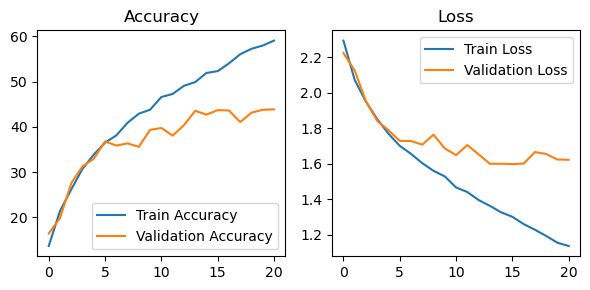


Testing combination: Learning Rate=0.01, Batch Size=64, Optimizer=Adam, Device = mps
Early stopping after 30 epochs.
Train Loss: 0.9411, Train Accuracy: 66.30%
Val Loss: 1.2731, Val Accuracy: 55.20%



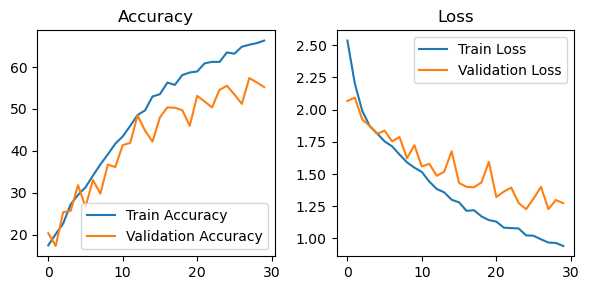


Testing combination: Learning Rate=0.01, Batch Size=128, Optimizer=SGD, Device = mps
Early stopping after 19 epochs.
Train Loss: 1.2466, Train Accuracy: 54.97%
Val Loss: 1.7347, Val Accuracy: 40.08%



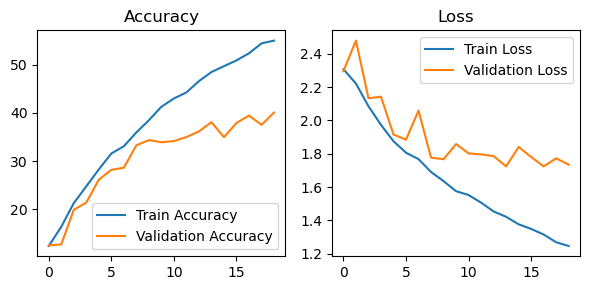


Testing combination: Learning Rate=0.01, Batch Size=128, Optimizer=Adam, Device = mps
Early stopping after 21 epochs.
Train Loss: 1.1875, Train Accuracy: 57.22%
Val Loss: 1.5249, Val Accuracy: 47.48%



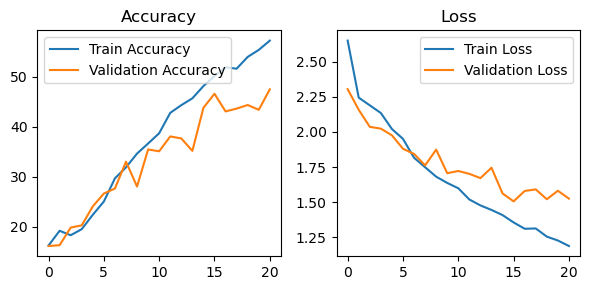


Testing combination: Learning Rate=0.001, Batch Size=32, Optimizer=SGD, Device = mps
Early stopping after 36 epochs.
Train Loss: 1.3617, Train Accuracy: 51.00%
Val Loss: 1.6235, Val Accuracy: 40.96%



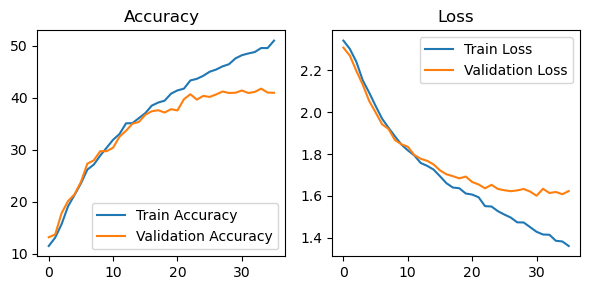


Testing combination: Learning Rate=0.001, Batch Size=32, Optimizer=Adam, Device = mps
Early stopping after 22 epochs.
Train Loss: 0.8171, Train Accuracy: 72.11%
Val Loss: 1.4755, Val Accuracy: 53.56%



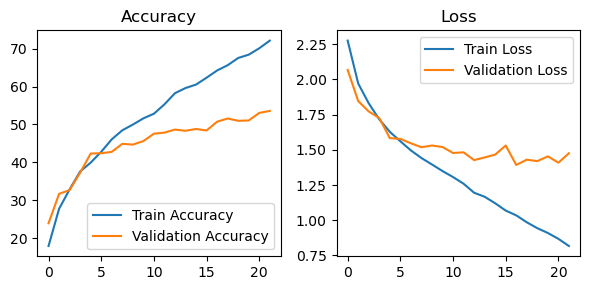


Testing combination: Learning Rate=0.001, Batch Size=64, Optimizer=SGD, Device = mps
Early stopping after 36 epochs.
Train Loss: 1.4480, Train Accuracy: 46.83%
Val Loss: 1.6752, Val Accuracy: 37.72%



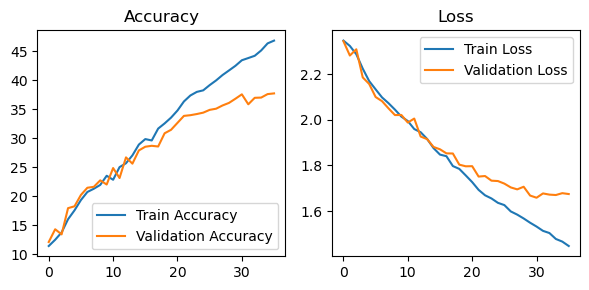


Testing combination: Learning Rate=0.001, Batch Size=64, Optimizer=Adam, Device = mps
Early stopping after 16 epochs.
Train Loss: 1.0047, Train Accuracy: 65.09%
Val Loss: 1.6352, Val Accuracy: 46.04%



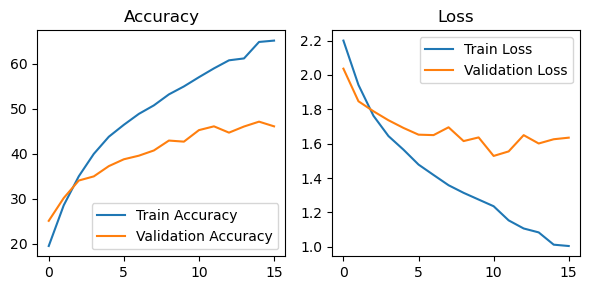


Testing combination: Learning Rate=0.001, Batch Size=128, Optimizer=SGD, Device = mps
Train Loss: 1.5217, Train Accuracy: 43.42%
Val Loss: 1.7631, Val Accuracy: 35.44%



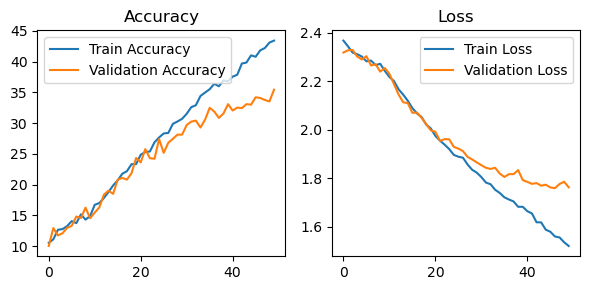


Testing combination: Learning Rate=0.001, Batch Size=128, Optimizer=Adam, Device = mps
Early stopping after 16 epochs.
Train Loss: 0.9524, Train Accuracy: 66.70%
Val Loss: 1.8068, Val Accuracy: 42.60%



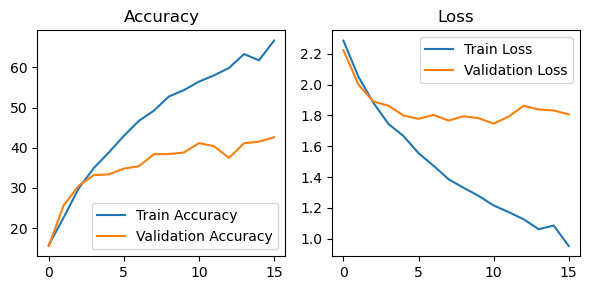


Testing combination: Learning Rate=0.0001, Batch Size=32, Optimizer=SGD, Device = mps
Train Loss: 1.9271, Train Accuracy: 27.25%
Val Loss: 1.9378, Val Accuracy: 26.56%



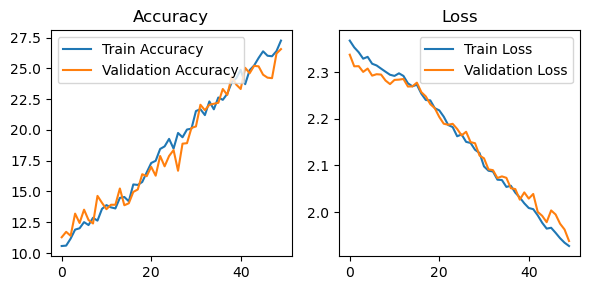


Testing combination: Learning Rate=0.0001, Batch Size=32, Optimizer=Adam, Device = mps
Early stopping after 21 epochs.
Train Loss: 1.4421, Train Accuracy: 47.26%
Val Loss: 1.9072, Val Accuracy: 31.16%



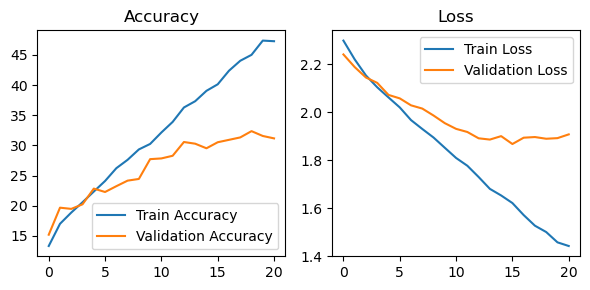


Testing combination: Learning Rate=0.0001, Batch Size=64, Optimizer=SGD, Device = mps
Train Loss: 2.0384, Train Accuracy: 23.12%
Val Loss: 2.0500, Val Accuracy: 21.96%



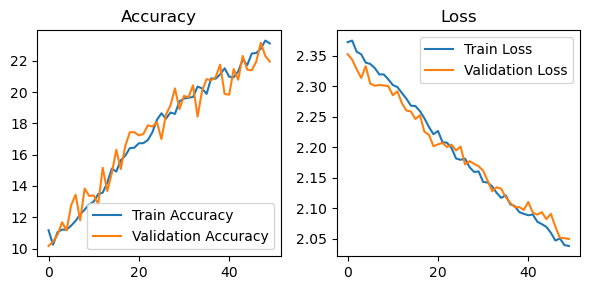


Testing combination: Learning Rate=0.0001, Batch Size=64, Optimizer=Adam, Device = mps
Early stopping after 21 epochs.
Train Loss: 1.3477, Train Accuracy: 50.90%
Val Loss: 2.1199, Val Accuracy: 27.00%



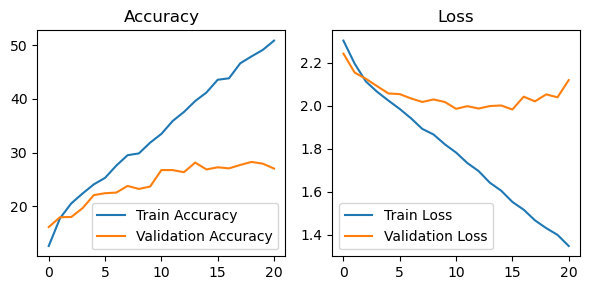


Testing combination: Learning Rate=0.0001, Batch Size=128, Optimizer=SGD, Device = mps
Early stopping after 6 epochs.
Train Loss: 2.3408, Train Accuracy: 10.77%
Val Loss: 2.3188, Val Accuracy: 11.60%



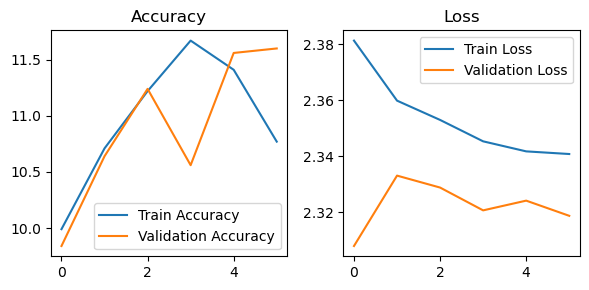


Testing combination: Learning Rate=0.0001, Batch Size=128, Optimizer=Adam, Device = mps
Early stopping after 16 epochs.
Train Loss: 1.6264, Train Accuracy: 41.05%
Val Loss: 2.1879, Val Accuracy: 22.00%



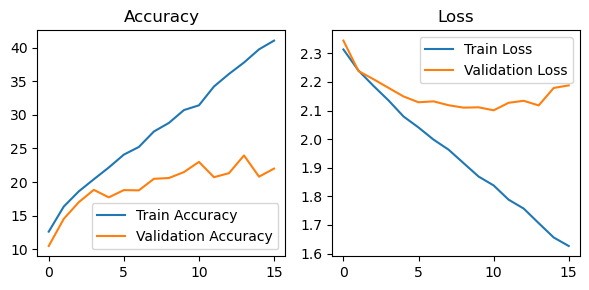


Best Configuration: {'learning_rate': 0.01, 'batch_size': 64, 'optimizer': 'Adam', 'best_train_loss': 0.941057487657875, 'best_train_accuracy': 66.3, 'best_val_loss': 1.2731202602386475, 'best_val_accuracy': 55.2}


In [119]:
# Hyperparameter optimisation
best_params, best_val_accuracy = run_mobilenet_experiment(
    train_dataset=train_dataset_subset,
    val_dataset=val_dataset_subset,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    optimizers=optimizers,
    epochs=epochs,
    patience=5,
    device=device
)

## 3. Further experiments with higher number of epochs

### 3.1 Resnet-18


Testing combination: Learning Rate=0.01, Batch Size=128, Optimizer=Adam, Device = mps
Early stopping after 27 epochs.
Train Loss: 0.3717, Train Accuracy: 86.67%
Val Loss: 1.2987, Val Accuracy: 63.84%



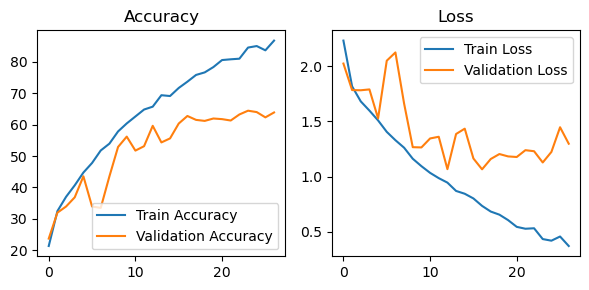


Best Configuration: {'learning_rate': 0.01, 'batch_size': 128, 'optimizer': 'Adam', 'modify_first_layer': True, 'best_train_loss': 0.3716929520987257, 'best_train_accuracy': 86.67, 'best_val_loss': 1.2987050026655198, 'best_val_accuracy': 63.84}


In [128]:
# Further Experiment 1: Chosen model with a higher number of epochs
best_params, best_val_accuracy = run_resnet18_experiment(
    train_dataset=train_dataset_subset,
    val_dataset=val_dataset_subset,
    learning_rates=[0.01],
    batch_sizes=[128],
    optimizers=[optim.Adam],
    epochs=100,
    patience=10,
    device=device,
    modify_first_layer=True
)


Testing combination: Learning Rate=0.0001, Batch Size=128, Optimizer=SGD, Device = mps
Train Loss: 1.9367, Train Accuracy: 32.49%
Val Loss: 1.9740, Val Accuracy: 28.12%



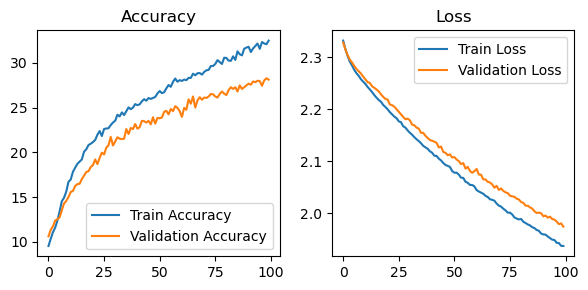


Best Configuration: {'learning_rate': 0.0001, 'batch_size': 128, 'optimizer': 'SGD', 'modify_first_layer': True, 'best_train_loss': 1.9367439369612103, 'best_train_accuracy': 32.49, 'best_val_loss': 1.9740473806858063, 'best_val_accuracy': 28.12}


In [129]:
# Further Experiment 2: Chosen model with a higher number of epochs
best_params, best_val_accuracy = run_resnet18_experiment(
    train_dataset=train_dataset_subset,
    val_dataset=val_dataset_subset,
    learning_rates=[0.0001],
    batch_sizes=[128],
    optimizers=[optim.SGD],
    epochs=100,
    patience=10,
    device=device,
    modify_first_layer=True
)


Testing combination: Learning Rate=0.0001, Batch Size=64, Optimizer=SGD, Device = mps
Train Loss: 1.7561, Train Accuracy: 38.96%
Val Loss: 1.7941, Val Accuracy: 33.96%



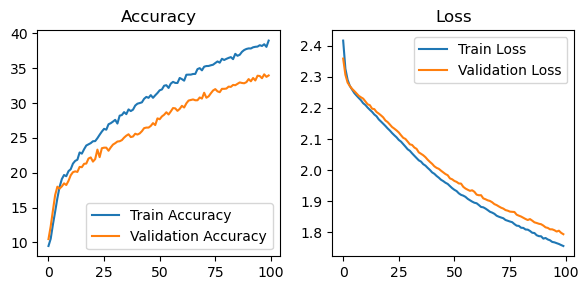


Best Configuration: {'learning_rate': 0.0001, 'batch_size': 64, 'optimizer': 'SGD', 'modify_first_layer': True, 'best_train_loss': 1.7561302868423947, 'best_train_accuracy': 38.96, 'best_val_loss': 1.7940911054611206, 'best_val_accuracy': 33.96}


In [130]:
# Further Experiment 3: Chosen model with a higher number of epochs
best_params, best_val_accuracy = run_resnet18_experiment(
    train_dataset=train_dataset_subset,
    val_dataset=val_dataset_subset,
    learning_rates=[0.0001],
    batch_sizes=[64],
    optimizers=[optim.SGD],
    epochs=100,
    patience=10,
    device=device,
    modify_first_layer=True
)

### 3.2 VGG-16


Testing combination: Learning Rate=0.0001, Batch Size=128, Optimizer=SGD, Device=mps
Train Loss: 1.5305, Train Accuracy: 44.45%
Val Loss: 1.6460, Val Accuracy: 39.44%



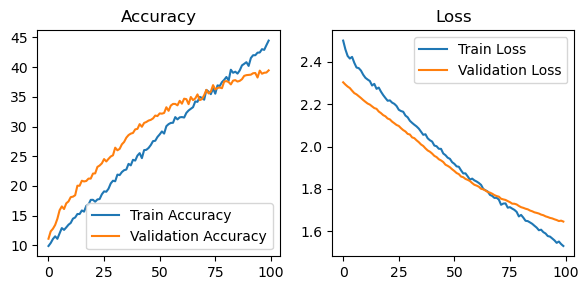


Best Configuration: {'learning_rate': 0.0001, 'batch_size': 128, 'optimizer': 'SGD', 'best_train_loss': 1.5304968296727048, 'best_train_accuracy': 44.45, 'best_val_loss': 1.6460124671459198, 'best_val_accuracy': 39.44}


In [131]:
# Further Experiment 1: Chosen model with a higher number of epochs
best_params, best_val_accuracy = run_vgg16_experiment(
    train_dataset=train_dataset_subset,
    val_dataset=val_dataset_subset,
    learning_rates=[0.0001],
    batch_sizes=[128],
    optimizers=[optim.SGD],
    epochs=100,
    patience=10,
    device=device,
    vgg16_getter=get_vgg16_modified
)

### 3.3 MobileNet


Testing combination: Learning Rate=0.0001, Batch Size=32, Optimizer=SGD, Device = mps
Train Loss: 1.6204, Train Accuracy: 38.83%
Val Loss: 1.7287, Val Accuracy: 35.08%



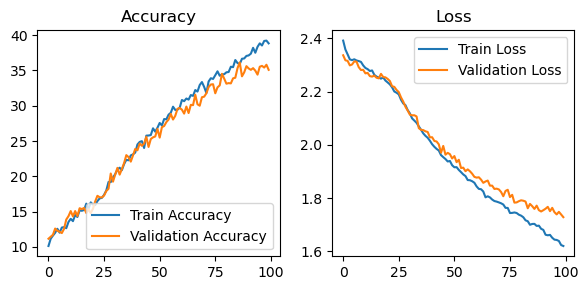


Best Configuration: {'learning_rate': 0.0001, 'batch_size': 32, 'optimizer': 'SGD', 'best_train_loss': 1.6203981763638629, 'best_train_accuracy': 38.83, 'best_val_loss': 1.7287408143659182, 'best_val_accuracy': 35.08}


In [132]:
# Further Experiment 1: Chosen model with a higher number of epochs
best_params, best_val_accuracy = run_mobilenet_experiment(
    train_dataset=train_dataset_subset,
    val_dataset=val_dataset_subset,
    learning_rates=[0.0001],
    batch_sizes=[32],
    optimizers=[optim.SGD],
    epochs=100,
    patience=10,
    device=device
)


Testing combination: Learning Rate=0.0001, Batch Size=64, Optimizer=SGD, Device = mps
Train Loss: 1.8888, Train Accuracy: 27.69%
Val Loss: 1.9419, Val Accuracy: 27.04%



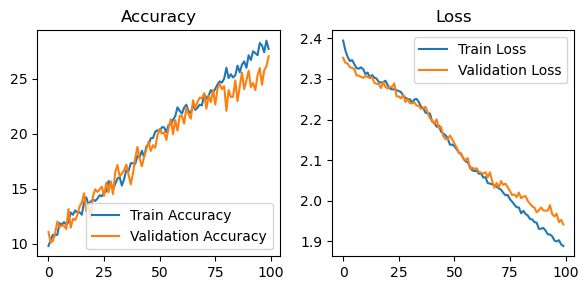


Best Configuration: {'learning_rate': 0.0001, 'batch_size': 64, 'optimizer': 'SGD', 'best_train_loss': 1.8888155707887784, 'best_train_accuracy': 27.69, 'best_val_loss': 1.9419014304876328, 'best_val_accuracy': 27.04}


In [133]:
# Further Experiment 1: Chosen model with a higher number of epochs
best_params, best_val_accuracy = run_mobilenet_experiment(
    train_dataset=train_dataset_subset,
    val_dataset=val_dataset_subset,
    learning_rates=[0.0001],
    batch_sizes=[64],
    optimizers=[optim.SGD],
    epochs=100,
    patience=10,
    device=device
)

## 4. Best model

In [136]:
# Using the best model for evaluation on the test set
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

In [137]:
# Define the optimizer and loss function
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [146]:
combined_dataset = ConcatDataset([train_dataset_subset, val_dataset_subset])

In [147]:
trainloader = torch.utils.data.DataLoader(combined_dataset, batch_size=32, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset_subset, batch_size=32, shuffle=False, num_workers=2)


In [148]:
# Training function
def train(model, trainloader, criterion, optimizer, device, epochs=25):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/total:.4f}, Accuracy: {100.*correct/total:.2f}%")

In [149]:
# Evaluation function
def evaluate(model, testloader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f"Test Loss: {test_loss/total:.4f}, Test Accuracy: {100.*correct/total:.2f}%")


In [150]:
# Train and evaluate the model
epochs = 30
train(model, trainloader, criterion, optimizer, device, epochs)
evaluate(model, testloader, criterion, device)

Epoch [1/30], Loss: 0.4204, Accuracy: 88.14%
Epoch [2/30], Loss: 0.2218, Accuracy: 93.27%
Epoch [3/30], Loss: 0.1728, Accuracy: 94.41%
Epoch [4/30], Loss: 0.1563, Accuracy: 94.74%
Epoch [5/30], Loss: 0.1422, Accuracy: 95.16%
Epoch [6/30], Loss: 0.1022, Accuracy: 96.46%
Epoch [7/30], Loss: 0.1164, Accuracy: 96.15%
Epoch [8/30], Loss: 0.0988, Accuracy: 96.88%
Epoch [9/30], Loss: 0.0931, Accuracy: 96.88%
Epoch [10/30], Loss: 0.0982, Accuracy: 96.82%
Epoch [11/30], Loss: 0.0936, Accuracy: 97.07%
Epoch [12/30], Loss: 0.0759, Accuracy: 97.35%
Epoch [13/30], Loss: 0.0666, Accuracy: 97.62%
Epoch [14/30], Loss: 0.0815, Accuracy: 97.27%
Epoch [15/30], Loss: 0.0811, Accuracy: 97.42%
Epoch [16/30], Loss: 0.0607, Accuracy: 98.01%
Epoch [17/30], Loss: 0.0757, Accuracy: 97.56%
Epoch [18/30], Loss: 0.0681, Accuracy: 97.89%
Epoch [19/30], Loss: 0.0421, Accuracy: 98.57%
Epoch [20/30], Loss: 0.0791, Accuracy: 97.31%
Epoch [21/30], Loss: 0.0720, Accuracy: 97.70%
Epoch [22/30], Loss: 0.0432, Accuracy: 98.5